In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from seiz_eeg.dataset import EEGDataset
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader  
from tqdm import tqdm
import torch
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GINEConv
from torch_geometric.utils import to_undirected
from torch_geometric.utils import add_self_loops
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool
from sklearn.metrics import f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import pywt
from scipy.signal import stft
from scipy.signal import welch
from sklearn.metrics import mutual_info_score
import numpy as np
from torch_geometric.utils import dropout_edge
from sklearn.model_selection import GroupShuffleSplit
from torch_geometric.data import Data
from scipy.signal import resample, correlate
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset, Subset, random_split

In [2]:
def seed_everything(seed: int):
    # Python random module
    random.seed(seed)
    # Numpy random module
    np.random.seed(seed)
    # Torch random seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.

    # Set PYTHONHASHSEED environment variable for hash-based operations
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Ensure deterministic behavior in cudnn (may slow down your training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1)

In [3]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

data_path = "..."

DATA_ROOT = Path(data_path)

### All preprocesses (chosen combined)

In [4]:
bp_filter = signal.butter(4, (0.5, 30), btype="bandpass", output="sos", fs=250)


def time_filtering(x: np.ndarray) -> np.ndarray:
    """Filter signal in the time domain"""
    return signal.sosfiltfilt(bp_filter, x, axis=0).copy()


def fft_filtering(x: np.ndarray) -> np.ndarray:
    """Compute FFT and only keep"""
    x = np.abs(np.fft.fft(x, axis=0))
    x = np.log(np.where(x > 1e-8, x, 1e-8))

    win_len = x.shape[0]
    # Only frequencies b/w 0.5 and 30Hz
    return x[int(0.5 * win_len // 250) : 30 * win_len // 250]


def stft_transform(x: np.ndarray, fs=250, nperseg=128, noverlap=64) -> np.ndarray:
    '''Divides the signal into overlapping windows and applies FFT to each segment'''
    features = []
    for ch in x.T:
        f, t, Zxx = signal.stft(ch, fs=fs, nperseg=nperseg, noverlap=noverlap)
        power = np.abs(Zxx) ** 2
        log_power = np.log1p(np.mean(power, axis=1))  # Mean over time
        features.append(log_power)
    return np.stack(features) 

def wavelet_energy(x, wavelet='db4', level=4):
    '''Extracts features from multichannel EEG data using the Discrete Wavelet Transform'''
    result = []
    for ch in x.T:
        coeffs = pywt.wavedec(ch, wavelet, level=level)
        energies = [np.log1p(np.sum(np.square(c))) for c in coeffs]
        result.append(energies)
    return np.stack(result)

def bandpower(x, fs=250):
    '''Estimates the signal power within standard EEG frequency bands (e.g., delta, theta, alpha, beta)'''
    bands = [(0.5, 4), (4, 8), (8, 12), (12, 30)]
    result = []
    for ch in x.T:
        f, Pxx = welch(ch, fs=fs, nperseg=256)
        bandpowers = [np.log1p(np.trapz(Pxx[(f >= low) & (f < high)], f[(f >= low) & (f < high)])) for low, high in bands]
        result.append(bandpowers)
    return np.stack(result)

def combined_transform(x):
    """Concatenate wavelet + bandpower + STFT per channel"""
    x = signal.sosfiltfilt(bp_filter, x, axis=0)  

    wvlt = wavelet_energy(x)    
    bp = bandpower(x)           
    stft = stft_transform(x)    

    assert wvlt.shape[0] == bp.shape[0] == stft.shape[0]

    out = np.concatenate([wvlt, bp, stft], axis=1)  # along features
    return out  

def normalize_features(feat: np.ndarray, axis=0, eps=1e-8) -> np.ndarray:
    """Z-score normalization per channel or feature"""
    mean = feat.mean(axis=axis, keepdims=True)
    std = feat.std(axis=axis, keepdims=True) + eps
    return (feat - mean) / std

def normalized_combined_transform(x):
    """Concatenate wavelet + bandpower + STFT per channel"""
    x = signal.sosfiltfilt(bp_filter, x, axis=0) 

    # Extract features
    wvlt = wavelet_energy(x)       
    bp   = bandpower(x)            
    stft = stft_transform(x)       

    # Normalize each separately
    wvlt = normalize_features(wvlt, axis=1)  
    bp   = normalize_features(bp, axis=1)
    stft = normalize_features(stft, axis=1)

    # Combine features along feature axis
    out = np.concatenate([wvlt, bp, stft], axis=1)
    return out


chosen_transform = combined_transform

### Dataset split by Patient IDs

In [5]:
clips_tr = pd.read_parquet("train/segments.parquet")

def extract_patient_id(path):
    fname = path.split("/")[-1].split(".")[0]
    return fname.split("_")[0]

clips_tr["patient_id"] = clips_tr["signals_path"].apply(extract_patient_id)

gss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, val_idx = next(
    gss.split(clips_tr, clips_tr["label"], clips_tr["patient_id"])
)

train_clips = clips_tr.iloc[train_idx].reset_index(drop=True)
val_clips   = clips_tr.iloc[val_idx].reset_index(drop=True)

print("Patients total:", clips_tr["patient_id"].nunique())
print("Train patients:", train_clips["patient_id"].nunique())
print("Val   patients:", val_clips["patient_id"].nunique())

dataset_tr = EEGDataset(
    train_clips,
    signals_root= "train",
    signal_transform=chosen_transform,
    prefetch=True,  # If your compute does not allow it, you can use prefetch=False
)

dataset_val = EEGDataset(
    val_clips,
    signals_root= "train",
    signal_transform=chosen_transform,
    prefetch=True,  # If your compute does not allow it, you can use prefetch=False
)

Patients total: 97
Train patients: 87
Val   patients: 10


## Correlation Based Graph Construction

In [6]:
def comp_xcorr(x, y, mode="valid", normalize=True):
    """
    Compute cross-correlation between 2 1D signals x, y
    Args:
        x: 1D array
        y: 1D array
        mode: 'valid', 'full' or 'same',
            refer to https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html
        normalize: If True, will normalize cross-correlation
    Returns:
        xcorr: cross-correlation of x and y
    """
    xcorr = correlate(x, y, mode=mode)
    # the below normalization code refers to matlab xcorr function
    cxx0 = np.sum(np.absolute(x) ** 2)
    cyy0 = np.sum(np.absolute(y) ** 2)
    if normalize and (cxx0 != 0) and (cyy0 != 0):
        scale = (cxx0 * cyy0) ** 0.5
        xcorr /= scale
    return xcorr
    
def keep_topk(adj_mat, top_k=3, directed=True):
    """ "
    Helper function to sparsen the adjacency matrix by keeping top-k neighbors
    for each node.
    Args:
        adj_mat: adjacency matrix, shape (num_nodes, num_nodes)
        top_k: int
        directed: whether or not a directed graph
    Returns:
        adj_mat: sparse adjacency matrix, directed graph
    """
    # Set values that are not of top-k neighbors to 0:
    adj_mat_noSelfEdge = adj_mat.copy()
    for i in range(adj_mat_noSelfEdge.shape[0]):
        adj_mat_noSelfEdge[i, i] = 0

    top_k_idx = (-adj_mat_noSelfEdge).argsort(axis=-1)[:, :top_k]

    mask = np.eye(adj_mat.shape[0], dtype=bool)
    for i in range(0, top_k_idx.shape[0]):
        for j in range(0, top_k_idx.shape[1]):
            mask[i, top_k_idx[i, j]] = 1
            if not directed:
                mask[top_k_idx[i, j], i] = 1  # symmetric

    adj_mat = mask * adj_mat
    return adj_mat

def ccor_edge_attr(dataset_tr, with_label):

    num_sensors = 19
    new_dataset = []
    labels = []

    for x in dataset_tr:

        if with_label:
            clip, label = x
            clip = clip.T
            labels.append(label)
        else:
            clip, idx = x
            clip = clip.T
            labels.append(idx)
            
        if clip.ndim == 2:
            clip = clip[:, :, None]
        adj_mat = np.eye(num_sensors, num_sensors, dtype=np.float32)
        
        clip = np.transpose(clip, (1, 0, 2))
        
        clip = clip.reshape((num_sensors, -1))
        # print(clip.shape)
        for i in range(0, num_sensors):
            for j in range(i + 1, num_sensors):
                xcorr = comp_xcorr(
                    clip[i, :], clip[j, :], mode='valid', normalize=True)
                adj_mat[i, j] = xcorr
                adj_mat[j, i] = xcorr
        adj_mat = abs(adj_mat)
        W = keep_topk(adj_mat, top_k=3, directed=True)
        src, dst, w = [], [], []
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                if W[i, j] != 0:
                    src.append(i); dst.append(j); w.append(W[i, j])
    
        edge_index = torch.tensor([src, dst], dtype=torch.long)
        edge_attr  = torch.tensor(w, dtype=torch.float).unsqueeze(-1)
        data = torch.tensor(clip, dtype=torch.float)
        if with_label:
            y = torch.tensor([label], dtype=torch.float)
            graph = Data(x=data, edge_index=edge_index, edge_attr=edge_attr, y=y)
        else:
            graph = Data(x=data, edge_index=edge_index, edge_attr=edge_attr, idx=idx)
        new_dataset.append(graph)
    
    return new_dataset, labels

dataset_tr_ccor, labels = ccor_edge_attr(dataset_tr, True) 
dataset_val_ccor, labels = ccor_edge_attr(dataset_val, True) 

loader_tr = DataLoader(dataset_tr_ccor, batch_size=2**8, shuffle=True)
loader_val = DataLoader(dataset_val_ccor, batch_size=2**8, shuffle=False)

## Check loaders

In [7]:
loader_tr = DataLoader(dataset_tr_ccor, batch_size=2**10, shuffle=True)
loader_val = DataLoader(dataset_val_ccor, batch_size=2**8, shuffle=False)
# loader_tr = DataLoader(dataset_tr_dist, batch_size=2**10, shuffle=True)
# loader_val = DataLoader(dataset_val_dist, batch_size=2**8, shuffle=False)

train_loader = loader_tr
val_loader = loader_val 
# all_loader = loader_all
d = dataset_tr_ccor[0]
input_dim = d.x.shape[1]
print(d)
d = dataset_val_ccor[0]
print(d)


Data(x=[19, 74], edge_index=[2, 76], edge_attr=[76, 1], y=[1])
Data(x=[19, 74], edge_index=[2, 76], edge_attr=[76, 1], y=[1])


### GIN
- Architecture with two GIN layers followed by concatenating add, mean and max pooling and a classification head.
- To include edge features into learning GINEConv is used instead of GINConv.
- Added random dropout of edges in training mode to help model generalize better.

In [8]:
class GIN_with_edge(torch.nn.Module):
    def __init__(self, input_dim=19, hidden_dim=64, dropout=0.2, edge_dim = 1):
        super().__init__()
        
        self.conv1 = GINEConv(
            Sequential(
                Linear(input_dim,  hidden_dim),
                BatchNorm1d(hidden_dim), ReLU(),
                #Dropout(0.2),
                Linear(hidden_dim, hidden_dim), ReLU()
            ),
            edge_dim=edge_dim,
        )
        
        self.conv2 = GINEConv(
            Sequential(
                Linear(hidden_dim, hidden_dim),
                BatchNorm1d(hidden_dim), ReLU(),
                # Dropout(0.2),
                Linear(hidden_dim, hidden_dim), ReLU()
            ),
            edge_dim=edge_dim,
        )

        self.lin1 = Linear(hidden_dim*3, hidden_dim)
        self.lin2 = Linear(hidden_dim, 1)
        self.dropout = dropout

    def forward(self, x, edge_index, edge_attr, batch):

        # Randomly drop edges
        if self.training:       
            E = edge_index.size(1)
            p = 0.2
            mask = torch.rand(E, device=edge_index.device) >= p
            edge_index = edge_index[:, mask]
            edge_attr = edge_attr[mask]
            
        h1 = self.conv1(x, edge_index, edge_attr)
        h2 = self.conv2(h1, edge_index, edge_attr)

        h_sum  = global_add_pool(h2, batch)
        h_mean = global_mean_pool(h2, batch)
        h_max  = global_max_pool(h2, batch)
        h = torch.cat([h_sum, h_mean, h_max], dim=1)
        
        h = self.lin1(h).relu()
        h = F.dropout(h, p=0.2, training=self.training)
        h = self.lin2(h).squeeze(1)

        return h

### Define model, optimizer, loss function

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model_with_edge = GIN_with_edge(input_dim=input_dim, hidden_dim=64, dropout=0.2).to(device)
optimizer = optim.Adam(model_with_edge.parameters(), lr=1e-4, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=5e-4,                   # 1e-3 to 5e-4
    total_steps=500,               # 1000 to 500
    pct_start=0.3,                 # 
    anneal_strategy='cos',         # 
    div_factor=25,                 # start LR = max_lr/div_factor
    final_div_factor=1e4           # 1e4 to 1e3
)

num_neg = 10476 
num_pos = 2517

pos_weight = num_neg / num_pos
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device))

Using device: cuda


In [10]:
save_filename = "GIN_results"

### Training Loop

In [11]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_probs = []
    all_targets = []
    total_loss = 0
    criterion = nn.BCEWithLogitsLoss()
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            logits = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)

            targets = batch.y.view(-1).int().cpu().numpy()
            probs = torch.sigmoid(logits).cpu().numpy()
            
            loss = criterion(logits, batch.y.float())
            total_loss += loss.item() * batch.num_graphs
            all_probs.extend(probs)
            all_targets.extend(targets)

        loss_all = total_loss / len(loader.dataset)
        best_thr, best_f1 = 0.5, 0.0
        all_probs   = np.array(all_probs)
        all_targets = np.array(all_targets)
        for thr in np.linspace(0.1, 0.9, 81):
            f1 = f1_score(all_targets, (all_probs > thr), average='macro')
            if f1 > best_f1:
                 best_f1, best_thr = f1, thr
        thr_middle = 0.5
        f1 =  f1_score(all_targets, (all_probs > thr_middle), average='macro')
    return best_f1, best_thr, f1, loss_all
    

device = "cuda" if torch.cuda.is_available() else "cpu"

train_f1s = []
val_f1s = []
best_val = 0
losses_val = []
losses_tr = []
for epoch in (range(1, 500)):
    model_with_edge.train()
    epoch_loss = 0.
    all_preds = []
    all_targets = []
    correct = 0
    total = 0
    for batch in tqdm(train_loader):
        batch = batch.to(device)
        # logits = model(batch.x, batch.edge_index, batch.batch)  # <- returns 1-D
        logits = model_with_edge(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        loss = criterion(logits, batch.y.float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        targets = batch.y.view(-1).int().cpu().numpy()
        preds = (logits > 0).int().cpu().numpy()
        
        all_preds.extend(preds)
        all_targets.extend(targets)
        
        epoch_loss += loss.item() * batch.num_graphs

    best_f1_tr, best_thr_tr, f1_tr, loss_tr = evaluate(model_with_edge, train_loader)
    train_f1s.append(f1_tr)
    losses_tr.append(loss_tr)

    print(f"epoch {epoch:02d}  loss {epoch_loss / len(train_loader.dataset):.4f} f1 best {best_f1_tr} thres {best_thr_tr} f1 {f1_tr}")

    
    best_f1_val, best_thr_val, f1_val, loss_val = evaluate(model_with_edge, val_loader)
    val_f1s.append(f1_val)
    losses_val.append(loss_val)
    print("F1 validation:", best_f1_val, "Threshold", best_thr_val, "F1", f1_val, "loss", loss_val)
    scheduler.step()
        
    if f1_val > best_val:
        best_val = f1_val
        torch.save(model_with_edge.state_dict(), save_filename + ".pt")


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.79it/s]


epoch 01  loss 1.1859 f1 best 0.450318865868605 thres 0.2 f1 0.44732080723729994
F1 validation: 0.6076523627971173 Threshold 0.15000000000000002 F1 0.43573667711598746 loss 0.5625483603389175


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 26.48it/s]


epoch 02  loss 1.1208 f1 best 0.5372264466547423 thres 0.29000000000000004 f1 0.44732080723729994
F1 validation: 0.5786534157409499 Threshold 0.26 F1 0.43573667711598746 loss 0.5221248531783068


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 25.74it/s]


epoch 03  loss 1.0799 f1 best 0.6346841083269092 thres 0.36 f1 0.4498546023133604
F1 validation: 0.5106426168657928 Threshold 0.4 F1 0.4442569847482791 loss 0.5399126752659127


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 25.72it/s]


epoch 04  loss 1.0540 f1 best 0.657735778261016 thres 0.41000000000000003 f1 0.48294621066498056
F1 validation: 0.5090718880621911 Threshold 0.31 F1 0.4709311740890688 loss 0.5520685617570524


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 26.02it/s]


epoch 05  loss 1.0324 f1 best 0.6637967224652132 thres 0.43000000000000005 f1 0.6220053680228129
F1 validation: 0.5185889329056357 Threshold 0.30000000000000004 F1 0.4763435920992191 loss 0.5559309445045613


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.08it/s]


epoch 06  loss 1.0204 f1 best 0.6662397269422726 thres 0.44000000000000006 f1 0.6507731423549439
F1 validation: 0.5374715439804733 Threshold 0.28 F1 0.4736473030209531 loss 0.5529409028865673


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.67it/s]


epoch 07  loss 0.9948 f1 best 0.6705010520657001 thres 0.45999999999999996 f1 0.6630942329037195
F1 validation: 0.5487388535031847 Threshold 0.27 F1 0.4792707292707292 loss 0.5480252122437512


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.30it/s]


epoch 08  loss 0.9881 f1 best 0.6778257857345544 thres 0.48 f1 0.6731227267021861
F1 validation: 0.5615983134611799 Threshold 0.26 F1 0.48269188281560693 loss 0.5417081473050294


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.22it/s]


epoch 09  loss 0.9698 f1 best 0.6827266447190284 thres 0.49 f1 0.6793576547780829
F1 validation: 0.5690648973667842 Threshold 0.24000000000000002 F1 0.48500743317158007 loss 0.5354079259766473


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.38it/s]


epoch 10  loss 0.9592 f1 best 0.6874700764338061 thres 0.5 f1 0.6874700764338061
F1 validation: 0.5832126387370887 Threshold 0.23 F1 0.48401046207497816 loss 0.5296928937788363


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.26it/s]


epoch 11  loss 0.9482 f1 best 0.6915510751840367 thres 0.51 f1 0.6889866657302446
F1 validation: 0.5896465067292374 Threshold 0.23 F1 0.4817102647173085 loss 0.5242107223581385


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.79it/s]


epoch 12  loss 0.9391 f1 best 0.6956180603143296 thres 0.52 f1 0.695066149305993
F1 validation: 0.6006998044663991 Threshold 0.22 F1 0.48550725911498394 loss 0.5168216486771902


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.73it/s]


epoch 13  loss 0.9292 f1 best 0.7001127257454076 thres 0.5 f1 0.7001127257454076
F1 validation: 0.6128073759716862 Threshold 0.21000000000000002 F1 0.48600799543118217 loss 0.5104889876312679


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.45it/s]


epoch 14  loss 0.9165 f1 best 0.7061702961469787 thres 0.53 f1 0.7052737806402636
F1 validation: 0.621773886562619 Threshold 0.2 F1 0.48550725911498394 loss 0.5040144113478837


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.35it/s]


epoch 15  loss 0.9163 f1 best 0.7100773678059273 thres 0.53 f1 0.7089192494211803
F1 validation: 0.6317863244883015 Threshold 0.2 F1 0.48550725911498394 loss 0.4976745960889039


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.41it/s]


epoch 16  loss 0.8984 f1 best 0.7131066032409976 thres 0.51 f1 0.7127096124870603
F1 validation: 0.6521485342019544 Threshold 0.21000000000000002 F1 0.4898153436131734 loss 0.49272505122202415


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.59it/s]


epoch 17  loss 0.8897 f1 best 0.7153928802931028 thres 0.52 f1 0.7145102240869854
F1 validation: 0.6928491441369381 Threshold 0.21000000000000002 F1 0.4851612903225806 loss 0.48637835041240407


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.46it/s]


epoch 18  loss 0.8857 f1 best 0.719557054103081 thres 0.52 f1 0.7162520040908016
F1 validation: 0.7218681798341335 Threshold 0.2 F1 0.48802030239736527 loss 0.47959936647503465


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.42it/s]


epoch 19  loss 0.8769 f1 best 0.7220622269596934 thres 0.52 f1 0.7189703439521795
F1 validation: 0.741452216986831 Threshold 0.19 F1 0.48124138335631106 loss 0.47799686005821934


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.77it/s]


epoch 20  loss 0.8701 f1 best 0.7254773984419398 thres 0.54 f1 0.7209889451372891
F1 validation: 0.7548799808686815 Threshold 0.18 F1 0.48470927607393366 loss 0.47572754632543635


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.65it/s]


epoch 21  loss 0.8575 f1 best 0.7262021441130457 thres 0.56 f1 0.7163614690883102
F1 validation: 0.7597941092364884 Threshold 0.19 F1 0.4885257854846406 loss 0.46762135867719296


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.19it/s]


epoch 22  loss 0.8534 f1 best 0.7291053831445802 thres 0.58 f1 0.7195653677934798
F1 validation: 0.7720450281425891 Threshold 0.2 F1 0.4885257854846406 loss 0.46267860929171245


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.17it/s]


epoch 23  loss 0.8518 f1 best 0.7321709156836851 thres 0.5700000000000001 f1 0.7194956568985005
F1 validation: 0.774582531414648 Threshold 0.19 F1 0.48226270373921376 loss 0.4573920275326128


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.33it/s]


epoch 24  loss 0.8478 f1 best 0.7331160907080772 thres 0.64 f1 0.7206212230984688
F1 validation: 0.7771822995780846 Threshold 0.21000000000000002 F1 0.4946687840290381 loss 0.45451885715678886


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.90it/s]


epoch 25  loss 0.8368 f1 best 0.7355986041816305 thres 0.63 f1 0.7228280453718339
F1 validation: 0.777300131061599 Threshold 0.19 F1 0.49519346118779894 loss 0.4529858060457088


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.25it/s]


epoch 26  loss 0.8385 f1 best 0.7392222249262073 thres 0.66 f1 0.7204059865761262
F1 validation: 0.7824067050970873 Threshold 0.2 F1 0.4903274269806902 loss 0.4468307780998724


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.11it/s]


epoch 27  loss 0.8290 f1 best 0.7400615940071619 thres 0.6 f1 0.7215404156819247
F1 validation: 0.7868047025793999 Threshold 0.22 F1 0.49084051724137934 loss 0.44115963721716844


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.23it/s]


epoch 28  loss 0.8160 f1 best 0.7415537545272268 thres 0.63 f1 0.7254364838907061
F1 validation: 0.7939700361500279 Threshold 0.22 F1 0.49084051724137934 loss 0.43449278120641355


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.74it/s]


epoch 29  loss 0.8121 f1 best 0.7429691004579857 thres 0.6 f1 0.7314749427849052
F1 validation: 0.7980307393836439 Threshold 0.21000000000000002 F1 0.4846656027335812 loss 0.4361171517107222


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.24it/s]


epoch 30  loss 0.8079 f1 best 0.7465207822520805 thres 0.63 f1 0.7302977765205959
F1 validation: 0.8029546933864573 Threshold 0.24000000000000002 F1 0.4946687840290381 loss 0.4241894515576186


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.61it/s]


epoch 31  loss 0.8027 f1 best 0.744757141498278 thres 0.62 f1 0.7339962826175741
F1 validation: 0.8060918847101098 Threshold 0.25 F1 0.5044922311033608 loss 0.4198881310445291


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.28it/s]


epoch 32  loss 0.8022 f1 best 0.7478303554901243 thres 0.6799999999999999 f1 0.7263515883940981
F1 validation: 0.8062671526665113 Threshold 0.26 F1 0.5526975476839238 loss 0.4144596741155342


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.60it/s]


epoch 33  loss 0.7891 f1 best 0.748685923489872 thres 0.69 f1 0.7297104217667217
F1 validation: 0.807307833312966 Threshold 0.26 F1 0.5650495260411119 loss 0.4080782806431806


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.68it/s]


epoch 34  loss 0.7895 f1 best 0.7491899938549453 thres 0.7 f1 0.7324363627059229
F1 validation: 0.8072318818279736 Threshold 0.26 F1 0.5679275696008791 loss 0.41057497020120975


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.41it/s]


epoch 35  loss 0.7788 f1 best 0.7501630116777676 thres 0.64 f1 0.7377575887759891
F1 validation: 0.8097391847571451 Threshold 0.27 F1 0.5657592456343188 loss 0.40602832867039573


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.37it/s]


epoch 36  loss 0.7825 f1 best 0.7536575969953443 thres 0.6799999999999999 f1 0.7210167538776067
F1 validation: 0.8110610142621184 Threshold 0.28 F1 0.6847995330363452 loss 0.3949206657983639


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.64it/s]


epoch 37  loss 0.7745 f1 best 0.7513848300825723 thres 0.67 f1 0.7341190659017213
F1 validation: 0.8070404497891613 Threshold 0.31 F1 0.6181215469613259 loss 0.4017841129391282


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.36it/s]


epoch 38  loss 0.7675 f1 best 0.7556227098021635 thres 0.65 f1 0.7435601925126643
F1 validation: 0.8114960838975176 Threshold 0.27 F1 0.5993643480923153 loss 0.4005047051994889


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.12it/s]


epoch 39  loss 0.7611 f1 best 0.7556794580593744 thres 0.74 f1 0.7365295585035603
F1 validation: 0.8114960838975176 Threshold 0.30000000000000004 F1 0.6548651356018658 loss 0.3951421987127375


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.49it/s]


epoch 40  loss 0.7604 f1 best 0.7560786757176319 thres 0.77 f1 0.7136935338132433
F1 validation: 0.8072318818279736 Threshold 0.35 F1 0.7679431236325847 loss 0.39175537802554944


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.11it/s]


epoch 41  loss 0.7539 f1 best 0.7576248524526115 thres 0.75 f1 0.7164244863368383
F1 validation: 0.8125 Threshold 0.36 F1 0.7643966208367192 loss 0.38703087899419997


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.36it/s]


epoch 42  loss 0.7514 f1 best 0.7615642006177379 thres 0.71 f1 0.7372048263816149
F1 validation: 0.8129367820708491 Threshold 0.32 F1 0.7278347308803899 loss 0.3853645968216437


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.47it/s]


epoch 43  loss 0.7491 f1 best 0.7609946829655649 thres 0.63 f1 0.750224229084387
F1 validation: 0.8123630869948382 Threshold 0.29000000000000004 F1 0.6334473049074819 loss 0.3944676314239149


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.49it/s]


epoch 44  loss 0.7439 f1 best 0.7613056011883406 thres 0.72 f1 0.7449686183074006
F1 validation: 0.7976291445590643 Threshold 0.30000000000000004 F1 0.6701067274946013 loss 0.3974361439545949


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.20it/s]


epoch 45  loss 0.7401 f1 best 0.7678378956508602 thres 0.71 f1 0.7438160149834131
F1 validation: 0.8081912527798369 Threshold 0.36 F1 0.723629024446311 loss 0.3899795939524969


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 25.35it/s]


epoch 46  loss 0.7368 f1 best 0.7691251904265208 thres 0.77 f1 0.7195574679285288
F1 validation: 0.8108790497752729 Threshold 0.37 F1 0.7708620780523007 loss 0.4011084094091698


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.60it/s]


epoch 47  loss 0.7315 f1 best 0.7654684963507727 thres 0.62 f1 0.7518076949301207
F1 validation: 0.7981451172940535 Threshold 0.33 F1 0.6747967479674797 loss 0.40299902812198357


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.41it/s]


epoch 48  loss 0.7256 f1 best 0.7715546188804046 thres 0.65 f1 0.7590216552542366
F1 validation: 0.8086569908867655 Threshold 0.33 F1 0.7084091301403513 loss 0.38899308012591466


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.28it/s]


epoch 49  loss 0.7220 f1 best 0.7736846535812311 thres 0.73 f1 0.7180491762300392
F1 validation: 0.8132586367880486 Threshold 0.45000000000000007 F1 0.804592060543659 loss 0.3895922815358197


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.81it/s]


epoch 50  loss 0.7171 f1 best 0.7802620064163619 thres 0.71 f1 0.7371097923245162
F1 validation: 0.8081964831054187 Threshold 0.36 F1 0.763741502495078 loss 0.3897658532416379


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.59it/s]


epoch 51  loss 0.7094 f1 best 0.7685885968624474 thres 0.74 f1 0.7327648122173307
F1 validation: 0.8034391780183807 Threshold 0.42000000000000004 F1 0.7595472867115864 loss 0.3997825211948819


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.38it/s]


epoch 52  loss 0.7037 f1 best 0.7812213460172505 thres 0.65 f1 0.7665227030902506
F1 validation: 0.7923035957316712 Threshold 0.25 F1 0.6266592920353982 loss 0.43211092794383016


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.68it/s]


epoch 53  loss 0.7055 f1 best 0.7747725647824447 thres 0.64 f1 0.7577926682989143
F1 validation: 0.8021294021294021 Threshold 0.30000000000000004 F1 0.687999537777093 loss 0.4056004580524233


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.43it/s]


epoch 54  loss 0.6986 f1 best 0.7861012817573039 thres 0.6799999999999999 f1 0.7593584168619052
F1 validation: 0.8031473792580692 Threshold 0.35 F1 0.7207073470769856 loss 0.40143632193406426


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.02it/s]


epoch 55  loss 0.6967 f1 best 0.7753476975913072 thres 0.77 f1 0.6918113614036298
F1 validation: 0.7964420860336654 Threshold 0.48 F1 0.7912786582551161 loss 0.4222759273317125


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.17it/s]


epoch 56  loss 0.6883 f1 best 0.7817759938143702 thres 0.66 f1 0.7445607743583138
F1 validation: 0.8146913483410463 Threshold 0.37 F1 0.7987147987147987 loss 0.371662974247226


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.71it/s]


epoch 57  loss 0.6798 f1 best 0.7846202455373308 thres 0.37 f1 0.7751865888534957
F1 validation: 0.7582161726515626 Threshold 0.24000000000000002 F1 0.49068085356222263 loss 0.47740050990272453


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.68it/s]


epoch 58  loss 0.6742 f1 best 0.7856941817876448 thres 0.59 f1 0.7808561773873655
F1 validation: 0.785571417366068 Threshold 0.27 F1 0.5747105829320767 loss 0.46245030650386104


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.80it/s]


epoch 59  loss 0.6770 f1 best 0.789116592335712 thres 0.83 f1 0.6756137347986488
F1 validation: 0.7945384540798355 Threshold 0.54 F1 0.786951871657754 loss 0.4459444891523432


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.25it/s]


epoch 60  loss 0.6629 f1 best 0.7895808600377836 thres 0.62 f1 0.7641104538158194
F1 validation: 0.7952063106796117 Threshold 0.36 F1 0.7604625002158175 loss 0.41121526901368743


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.84it/s]


epoch 61  loss 0.6584 f1 best 0.7955934562810854 thres 0.49 f1 0.7952857554101956
F1 validation: 0.7620310817048777 Threshold 0.23 F1 0.5149825783972125 loss 0.48984263627617447


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.62it/s]


epoch 62  loss 0.6573 f1 best 0.7738265671523558 thres 0.47 f1 0.7707973692915167
F1 validation: 0.7473854012636107 Threshold 0.31 F1 0.5700629659556952 loss 0.4871126424383234


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.53it/s]


epoch 63  loss 0.6589 f1 best 0.8005156205445509 thres 0.61 f1 0.7899262343040908
F1 validation: 0.7632049928869716 Threshold 0.32 F1 0.6697130030463363 loss 0.471485512510494


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.55it/s]


epoch 64  loss 0.6495 f1 best 0.7902586521288102 thres 0.31 f1 0.7652288994623162
F1 validation: 0.733048128342246 Threshold 0.1 F1 0.4742335493519442 loss 0.6169649514335173


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.79it/s]


epoch 65  loss 0.6402 f1 best 0.7991456872947171 thres 0.54 f1 0.7974883553980492
F1 validation: 0.7682555305285691 Threshold 0.24000000000000002 F1 0.6334904210634156 loss 0.4960926279425621


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.86it/s]


epoch 66  loss 0.6426 f1 best 0.7997352004930327 thres 0.66 f1 0.7867190515532152
F1 validation: 0.7476632292314351 Threshold 0.33999999999999997 F1 0.6542337772702527 loss 0.5205656504741422


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.26it/s]


epoch 67  loss 0.6367 f1 best 0.7903025729932295 thres 0.85 f1 0.6629969916209365
F1 validation: 0.7282608695652174 Threshold 0.58 F1 0.7092353525322741 loss 0.5235698781631611


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.72it/s]


epoch 68  loss 0.6324 f1 best 0.7843578979879586 thres 0.64 f1 0.775452794665367
F1 validation: 0.7693307703418927 Threshold 0.33 F1 0.6815089672232529 loss 0.4419497102499008


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.58it/s]


epoch 69  loss 0.6393 f1 best 0.7976750961480044 thres 0.69 f1 0.7617266141663361
F1 validation: 0.7626841243862521 Threshold 0.39 F1 0.7487684729064039 loss 0.478677706806748


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.27it/s]


epoch 70  loss 0.6214 f1 best 0.7958939630467492 thres 0.8099999999999999 f1 0.7219982627053025
F1 validation: 0.798766209240841 Threshold 0.55 F1 0.7943610007962453 loss 0.4273826563799823


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.79it/s]


epoch 71  loss 0.6212 f1 best 0.7891841094845642 thres 0.69 f1 0.7832091724430665
F1 validation: 0.7005565478563329 Threshold 0.12000000000000001 F1 0.5144018232241412 loss 0.6550758766907233


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.23it/s]


epoch 72  loss 0.6062 f1 best 0.7991403050002049 thres 0.88 f1 0.6719997797362744
F1 validation: 0.8004207465497681 Threshold 0.64 F1 0.7848254876745575 loss 0.4417664236492581


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.13it/s]


epoch 73  loss 0.6151 f1 best 0.7905144756076262 thres 0.84 f1 0.7061110339304999
F1 validation: 0.6601619540687641 Threshold 0.48 F1 0.6573586805992697 loss 0.6240780132788198


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.20it/s]


epoch 74  loss 0.6122 f1 best 0.7714871252666031 thres 0.85 f1 0.6919054834911471
F1 validation: 0.8177562089637453 Threshold 0.65 F1 0.7854032868110403 loss 0.3914009028010898


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.38it/s]


epoch 75  loss 0.6132 f1 best 0.8027083877873616 thres 0.71 f1 0.7558390827806551
F1 validation: 0.756412421470434 Threshold 0.33 F1 0.7171621383203952 loss 0.48492941436944187


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.35it/s]


epoch 76  loss 0.6007 f1 best 0.8027552427006959 thres 0.73 f1 0.7603329500495388
F1 validation: 0.7457080275062968 Threshold 0.45999999999999996 F1 0.7353686900121204 loss 0.4888351316805239


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.81it/s]


epoch 77  loss 0.6027 f1 best 0.7965100130495191 thres 0.8 f1 0.7125759436767412
F1 validation: 0.7363549187000891 Threshold 0.48 F1 0.733048128342246 loss 0.5101449659577122


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.15it/s]


epoch 78  loss 0.5912 f1 best 0.8066566674635791 thres 0.85 f1 0.7082273102180515
F1 validation: 0.7669676816399591 Threshold 0.59 F1 0.7597946963216424 loss 0.48789915486618324


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.78it/s]


epoch 79  loss 0.5829 f1 best 0.7804096799821769 thres 0.47 f1 0.7764281438946008
F1 validation: 0.543477648252346 Threshold 0.18 F1 0.5106949669128751 loss 0.8375288251373503


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.50it/s]


epoch 80  loss 0.5951 f1 best 0.8124054489603891 thres 0.78 f1 0.7504466103889604
F1 validation: 0.7910714285714286 Threshold 0.44000000000000006 F1 0.7664936990363231 loss 0.41646596822473736


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.03it/s]


epoch 81  loss 0.5880 f1 best 0.8110194011620377 thres 0.61 f1 0.7927194326241135
F1 validation: 0.7408619749045281 Threshold 0.35 F1 0.6786269503381385 loss 0.5194389368648882


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.40it/s]


epoch 82  loss 0.5714 f1 best 0.8115929910911315 thres 0.65 f1 0.7995552554211772
F1 validation: 0.8103848189160183 Threshold 0.18 F1 0.6747967479674797 loss 0.46986788652009437


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.55it/s]


epoch 83  loss 0.5846 f1 best 0.8075113278438193 thres 0.52 f1 0.8053719236004949
F1 validation: 0.7565853557439224 Threshold 0.31 F1 0.6943995472585885 loss 0.5134119063615799


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.57it/s]


epoch 84  loss 0.5784 f1 best 0.800247153493032 thres 0.32 f1 0.7867951873942565
F1 validation: 0.6018384250497701 Threshold 0.1 F1 0.46959241076888136 loss 0.8746128855480089


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.99it/s]


epoch 85  loss 0.5747 f1 best 0.7407993458628093 thres 0.9 f1 0.5078444458548015
F1 validation: 0.6401064685030678 Threshold 0.76 F1 0.6039499422591973 loss 0.872730412306609


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.33it/s]


epoch 86  loss 0.5773 f1 best 0.7853829489717631 thres 0.79 f1 0.7256489488118145
F1 validation: 0.6446261498545484 Threshold 0.18 F1 0.6046353271903795 loss 0.6279881166087257


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.89it/s]


epoch 87  loss 0.5797 f1 best 0.7917774747641634 thres 0.9 f1 0.62980786031866
F1 validation: 0.8164406773063955 Threshold 0.84 F1 0.7317118675340231 loss 0.5123687510137205


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.90it/s]


epoch 88  loss 0.5649 f1 best 0.8205743385240512 thres 0.8 f1 0.7566370324540717
F1 validation: 0.7910023765827547 Threshold 0.42000000000000004 F1 0.7657208291536894 loss 0.43794144612771496


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.78it/s]


epoch 89  loss 0.5668 f1 best 0.8039366530556248 thres 0.86 f1 0.6802582982148776
F1 validation: 0.7416380322734983 Threshold 0.59 F1 0.7296286941146755 loss 0.522856327339455


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.81it/s]


epoch 90  loss 0.5770 f1 best 0.8088795328827887 thres 0.69 f1 0.7976977779225329
F1 validation: 0.7989824265692793 Threshold 0.12000000000000001 F1 0.7078262083730888 loss 0.4510620104493918


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.01it/s]


epoch 91  loss 0.5644 f1 best 0.800969817270857 thres 0.84 f1 0.6692531855368695
F1 validation: 0.7784206049160678 Threshold 0.63 F1 0.7308775355894246 loss 0.5301307148403591


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.22it/s]


epoch 92  loss 0.5776 f1 best 0.7944275222520119 thres 0.76 f1 0.7674244563866355
F1 validation: 0.6564819277108433 Threshold 0.36 F1 0.6457575423510822 loss 0.7125417270042278


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.74it/s]


epoch 93  loss 0.5693 f1 best 0.8211003248765383 thres 0.45999999999999996 f1 0.8189920407146589
F1 validation: 0.7956010230179028 Threshold 0.13 F1 0.5690411358638425 loss 0.5196759485812099


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.08it/s]


epoch 94  loss 0.5375 f1 best 0.8236926464547176 thres 0.83 f1 0.7233073831539305
F1 validation: 0.786096256684492 Threshold 0.71 F1 0.747834041502032 loss 0.48352125574041294


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.91it/s]


epoch 95  loss 0.5454 f1 best 0.7736424793832011 thres 0.9 f1 0.7058705600835968
F1 validation: 0.6581929416867677 Threshold 0.31 F1 0.5986306221225357 loss 0.6904055582152473


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.33it/s]


epoch 96  loss 0.5402 f1 best 0.7743937531922217 thres 0.5700000000000001 f1 0.7701369750047042
F1 validation: 0.755997288858765 Threshold 0.1 F1 0.6710345961949669 loss 0.622304745901514


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.15it/s]


epoch 97  loss 0.5576 f1 best 0.699214454448094 thres 0.9 f1 0.5959147060826987
F1 validation: 0.7350184693347986 Threshold 0.86 F1 0.6596167536782155 loss 0.7667887493416116


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.83it/s]


epoch 98  loss 0.5618 f1 best 0.8074097852255512 thres 0.55 f1 0.8055317935557457
F1 validation: 0.7914774829314231 Threshold 0.15000000000000002 F1 0.6377088914402347 loss 0.560296769992069


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.24it/s]


epoch 99  loss 0.5326 f1 best 0.817743882848935 thres 0.56 f1 0.8132673506243628
F1 validation: 0.7489601827902215 Threshold 0.19 F1 0.6199456887316575 loss 0.5319808422415345


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.77it/s]


epoch 100  loss 0.5360 f1 best 0.7843244302076602 thres 0.67 f1 0.7735296554871902
F1 validation: 0.5576444447806648 Threshold 0.1 F1 0.5035339657924608 loss 0.8512657183739875


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.15it/s]


epoch 101  loss 0.5252 f1 best 0.825638746180581 thres 0.86 f1 0.7068461068747767
F1 validation: 0.8273537210837618 Threshold 0.6 F1 0.8105555365886106 loss 0.4270933049696463


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.93it/s]


epoch 102  loss 0.5347 f1 best 0.7992134258725325 thres 0.89 f1 0.7296677789061367
F1 validation: 0.7866024096385542 Threshold 0.44000000000000006 F1 0.7773543651413399 loss 0.5357060067079685


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.99it/s]


epoch 103  loss 0.5428 f1 best 0.8119489031676292 thres 0.62 f1 0.801017323800583
F1 validation: 0.6373116284160618 Threshold 0.19 F1 0.562231420210382 loss 0.6457961941758792


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.98it/s]


epoch 104  loss 0.5235 f1 best 0.830878176758528 thres 0.8 f1 0.7779005595761058
F1 validation: 0.8079888636567101 Threshold 0.47 F1 0.8051195510735198 loss 0.43662563551355293


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.01it/s]


epoch 105  loss 0.5169 f1 best 0.8218271980656818 thres 0.77 f1 0.764983240297008
F1 validation: 0.7720014789884793 Threshold 0.5700000000000001 F1 0.7635248721246748 loss 0.4966075954613862


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.14it/s]


epoch 106  loss 0.5123 f1 best 0.8305899387273741 thres 0.67 f1 0.8200086411236098
F1 validation: 0.7628711736821077 Threshold 0.24000000000000002 F1 0.7350801393728223 loss 0.5544519232379066


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.60it/s]


epoch 107  loss 0.5103 f1 best 0.8188791605565992 thres 0.75 f1 0.799016524943017
F1 validation: 0.7117745193396161 Threshold 0.26 F1 0.6393473905161721 loss 0.6188237310559661


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.01it/s]


epoch 108  loss 0.5188 f1 best 0.8088366533864542 thres 0.9 f1 0.71732674009419
F1 validation: 0.7605783132530121 Threshold 0.66 F1 0.740244700893911 loss 0.647981592019399


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.78it/s]


epoch 109  loss 0.5244 f1 best 0.8302634596761485 thres 0.86 f1 0.7531404721738739
F1 validation: 0.8444560701646406 Threshold 0.56 F1 0.8392761862818523 loss 0.3660408393100456


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.04it/s]


epoch 110  loss 0.5032 f1 best 0.813560302812429 thres 0.9 f1 0.6710666320278813
F1 validation: 0.7102409526120308 Threshold 0.73 F1 0.6783790006907668 loss 0.6329402181837294


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.42it/s]


epoch 111  loss 0.5032 f1 best 0.8093161649804996 thres 0.83 f1 0.7791028371414943
F1 validation: 0.8226950354609929 Threshold 0.35 F1 0.8083170420348369 loss 0.4259268229758298


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.90it/s]


epoch 112  loss 0.5105 f1 best 0.8037161121002955 thres 0.82 f1 0.7651129308158584
F1 validation: 0.7287771357176324 Threshold 0.42000000000000004 F1 0.7183744993324432 loss 0.6545399105107342


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.22it/s]


epoch 113  loss 0.5069 f1 best 0.8122379931288459 thres 0.82 f1 0.7552644156048165
F1 validation: 0.7297973480110083 Threshold 0.33999999999999997 F1 0.721117731933782 loss 0.5130680761955403


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.71it/s]


epoch 114  loss 0.4956 f1 best 0.807091001127558 thres 0.9 f1 0.6737541853746114
F1 validation: 0.7865337295880868 Threshold 0.75 F1 0.745827485695779 loss 0.586815599821232


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.54it/s]


epoch 115  loss 0.5162 f1 best 0.8041978605575821 thres 0.64 f1 0.7942535523954997
F1 validation: 0.8080469218635444 Threshold 0.54 F1 0.806053361371609 loss 0.39757219514361136


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.66it/s]


epoch 116  loss 0.4999 f1 best 0.8093247780026845 thres 0.44000000000000006 f1 0.8092288919369267
F1 validation: 0.8025417392214395 Threshold 0.13 F1 0.7358941776398205 loss 0.521215560094074


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.76it/s]


epoch 117  loss 0.5012 f1 best 0.7537085666381742 thres 0.83 f1 0.7081022621321325
F1 validation: 0.6385810961552763 Threshold 0.13 F1 0.5368970013037809 loss 0.7175579751531284


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.19it/s]


epoch 118  loss 0.4919 f1 best 0.835561065012491 thres 0.78 f1 0.7753534898944441
F1 validation: 0.730096757766084 Threshold 0.49 F1 0.7260884405339806 loss 0.5682081251232712


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.77it/s]


epoch 119  loss 0.4844 f1 best 0.8101035451472426 thres 0.8 f1 0.7818251744409648
F1 validation: 0.7752822660620006 Threshold 0.62 F1 0.7660199620807127 loss 0.49659488212179254


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.24it/s]


epoch 120  loss 0.4817 f1 best 0.8396935576103084 thres 0.74 f1 0.8104270252085503
F1 validation: 0.796246156670185 Threshold 0.38 F1 0.7887949260042284 loss 0.49522789584265814


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.25it/s]


epoch 121  loss 0.4886 f1 best 0.8369996283545302 thres 0.82 f1 0.7730035089715366
F1 validation: 0.8275414678935706 Threshold 0.69 F1 0.8135463521155677 loss 0.4151350074344211


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.48it/s]


epoch 122  loss 0.5019 f1 best 0.8109490513275416 thres 0.76 f1 0.7678213512662004
F1 validation: 0.795723868457886 Threshold 0.53 F1 0.7887868924053747 loss 0.39524774131951507


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.83it/s]


epoch 123  loss 0.5033 f1 best 0.8364164071148739 thres 0.82 f1 0.7776929537910113
F1 validation: 0.8226958798221946 Threshold 0.48 F1 0.8221538391917729 loss 0.4007998107208146


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.85it/s]


epoch 124  loss 0.4770 f1 best 0.8367787870300087 thres 0.61 f1 0.8303391954687132
F1 validation: 0.775137047684447 Threshold 0.25 F1 0.6908691918710047 loss 0.6099191606044769


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.51it/s]


epoch 125  loss 0.4858 f1 best 0.7811663664521149 thres 0.9 f1 0.6135822151125644
F1 validation: 0.7315199342251819 Threshold 0.7 F1 0.6832675974544486 loss 0.6902814979906435


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.24it/s]


epoch 126  loss 0.4764 f1 best 0.8172767805925666 thres 0.45000000000000007 f1 0.8149225843370285
F1 validation: 0.8074036855718076 Threshold 0.14 F1 0.7402597402597402 loss 0.57974409022265


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 25.45it/s]


epoch 127  loss 0.4820 f1 best 0.8040896091555576 thres 0.89 f1 0.7159561293677348
F1 validation: 0.7975768818573715 Threshold 0.64 F1 0.7847456410992323 loss 0.46153762715834157


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.50it/s]


epoch 128  loss 0.4740 f1 best 0.8210527384151872 thres 0.8 f1 0.7782031870124027
F1 validation: 0.8231961586800296 Threshold 0.48 F1 0.8186501856844028 loss 0.3915667509591138


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.95it/s]


epoch 129  loss 0.4669 f1 best 0.8394414935732881 thres 0.74 f1 0.8251449355990992
F1 validation: 0.7943710525685335 Threshold 0.18 F1 0.7330681818181818 loss 0.5413690922298917


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.20it/s]


epoch 130  loss 0.4742 f1 best 0.8367810837791837 thres 0.55 f1 0.8331648742851034
F1 validation: 0.7821638776968278 Threshold 0.24000000000000002 F1 0.759163763066202 loss 0.4934091798685215


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.08it/s]


epoch 131  loss 0.4692 f1 best 0.7964803429731304 thres 0.33 f1 0.7914163638674705
F1 validation: 0.7551613237887748 Threshold 0.11 F1 0.5607167645588137 loss 0.6536734026891214


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.08it/s]


epoch 132  loss 0.4632 f1 best 0.8431180881124043 thres 0.59 f1 0.8353437192374238
F1 validation: 0.768557217172483 Threshold 0.28 F1 0.7401289282836423 loss 0.547707838482327


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.51it/s]


epoch 133  loss 0.4772 f1 best 0.7746270769906395 thres 0.9 f1 0.5732084219431222
F1 validation: 0.8209824188667785 Threshold 0.89 F1 0.7248559211749396 loss 0.6708641290664673


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.37it/s]


epoch 134  loss 0.4692 f1 best 0.817305686140494 thres 0.36 f1 0.8087818254983791
F1 validation: 0.7388949064291461 Threshold 0.1 F1 0.5750988962465077 loss 0.7748178412516912


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.31it/s]


epoch 135  loss 0.4706 f1 best 0.7823954619532203 thres 0.9 f1 0.6411329987862633
F1 validation: 0.80997800671374 Threshold 0.9 F1 0.6796824317771599 loss 0.7905951588242143


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.94it/s]


epoch 136  loss 0.4606 f1 best 0.838330761019987 thres 0.82 f1 0.7835789504585925
F1 validation: 0.7492750258655742 Threshold 0.67 F1 0.7411323163590615 loss 0.5732874151733186


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.79it/s]


epoch 137  loss 0.4550 f1 best 0.8291488655062574 thres 0.9 f1 0.6548881570191063
F1 validation: 0.7691528713976856 Threshold 0.85 F1 0.6978284711559553 loss 0.6669853563661928


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.24it/s]


epoch 138  loss 0.4557 f1 best 0.8167979347114473 thres 0.9 f1 0.6481532305696038
F1 validation: 0.7493811881188119 Threshold 0.78 F1 0.6711053925672639 loss 0.6292633228831821


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.67it/s]


epoch 139  loss 0.4535 f1 best 0.8046292451146679 thres 0.14 f1 0.752352164483983
F1 validation: 0.6394526287143674 Threshold 0.1 F1 0.48216340621403914 loss 0.8714135413368543


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.44it/s]


epoch 140  loss 0.4483 f1 best 0.8447045451298397 thres 0.79 f1 0.8029419605610698
F1 validation: 0.7772936335027838 Threshold 0.53 F1 0.7739080787896089 loss 0.566175972532343


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.19it/s]


epoch 141  loss 0.4414 f1 best 0.828251125010774 thres 0.36 f1 0.8247622170408432
F1 validation: 0.739997111079012 Threshold 0.11 F1 0.5962013011291408 loss 0.6771629626552264


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.05it/s]


epoch 142  loss 0.4446 f1 best 0.8394016204612623 thres 0.79 f1 0.8077352770994894
F1 validation: 0.7583770760832877 Threshold 0.55 F1 0.7507940570863685 loss 0.577606177661154


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.30it/s]


epoch 143  loss 0.4498 f1 best 0.8400998531508341 thres 0.75 f1 0.8222178961217768
F1 validation: 0.7993161409899978 Threshold 0.14 F1 0.7557160658497366 loss 0.5326294759357417


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.92it/s]


epoch 144  loss 0.4521 f1 best 0.8130151148705298 thres 0.89 f1 0.6712928861611083
F1 validation: 0.7328322235385432 Threshold 0.8 F1 0.683354728284125 loss 0.7325062954867327


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.76it/s]


epoch 145  loss 0.4567 f1 best 0.7963016863358887 thres 0.85 f1 0.7811268061473922
F1 validation: 0.8017530173007205 Threshold 0.5700000000000001 F1 0.7998181770038042 loss 0.4960255093044705


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.23it/s]


epoch 146  loss 0.4434 f1 best 0.8274237186634645 thres 0.9 f1 0.6694352989255667
F1 validation: 0.7749823515569849 Threshold 0.87 F1 0.7157522170656385 loss 0.6330447090996636


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.65it/s]


epoch 147  loss 0.4465 f1 best 0.7963446160278858 thres 0.79 f1 0.7844113655149858
F1 validation: 0.7788642827469402 Threshold 0.18 F1 0.7182853664898705 loss 0.7003395012959286


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.31it/s]


epoch 148  loss 0.4440 f1 best 0.8069249378881891 thres 0.69 f1 0.8008924989971922
F1 validation: 0.7492435055666571 Threshold 0.27 F1 0.7429388674946446 loss 0.7345930879245753


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.74it/s]


epoch 149  loss 0.4436 f1 best 0.8283987809215043 thres 0.9 f1 0.701014937959282
F1 validation: 0.7960468336900415 Threshold 0.85 F1 0.7355742296918768 loss 0.5615043741685373


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.14it/s]


epoch 150  loss 0.4413 f1 best 0.8238699611853266 thres 0.76 f1 0.8104025449925901
F1 validation: 0.8098214285714286 Threshold 0.28 F1 0.7991238380168821 loss 0.4787916113105085


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.61it/s]


epoch 151  loss 0.4361 f1 best 0.8290243151738996 thres 0.77 f1 0.7926876120180486
F1 validation: 0.7985064602311454 Threshold 0.55 F1 0.7884236540115912 loss 0.5037227091965852


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.59it/s]


epoch 152  loss 0.4320 f1 best 0.799135654273162 thres 0.9 f1 0.6189547315169619
F1 validation: 0.7342601420970074 Threshold 0.88 F1 0.6564700685530798 loss 0.8703638067951909


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.31it/s]


epoch 153  loss 0.4210 f1 best 0.8405025527232908 thres 0.53 f1 0.8393463500579006
F1 validation: 0.7962745307547103 Threshold 0.16 F1 0.7338464005130672 loss 0.6568693616324001


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.23it/s]


epoch 154  loss 0.4140 f1 best 0.8559489383023513 thres 0.8099999999999999 f1 0.7992895470155528
F1 validation: 0.7951338789087024 Threshold 0.63 F1 0.7718917112299465 loss 0.5134492576122284


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.01it/s]


epoch 155  loss 0.4367 f1 best 0.8281880577941751 thres 0.43000000000000005 f1 0.8274208775234371
F1 validation: 0.7186635407060078 Threshold 0.14 F1 0.6453813784369 loss 0.7722915393334848


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.33it/s]


epoch 156  loss 0.4222 f1 best 0.8591089215159226 thres 0.85 f1 0.8202242441824315
F1 validation: 0.8254028129546802 Threshold 0.6 F1 0.821594114282333 loss 0.4479837530740985


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.07it/s]


epoch 157  loss 0.4076 f1 best 0.8123111207683384 thres 0.9 f1 0.6654710199305112
F1 validation: 0.8097391847571451 Threshold 0.87 F1 0.7612369092797313 loss 0.5925164522948089


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.38it/s]


epoch 158  loss 0.4248 f1 best 0.7985290208130169 thres 0.59 f1 0.7937288911252719
F1 validation: 0.6851327002212866 Threshold 0.45999999999999996 F1 0.6823835632151647 loss 0.7089576807287005


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.25it/s]


epoch 159  loss 0.4321 f1 best 0.8677778936795185 thres 0.72 f1 0.8510621099959088
F1 validation: 0.7910519316015092 Threshold 0.33999999999999997 F1 0.7821324448681757 loss 0.5531281562866988


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.77it/s]


epoch 160  loss 0.4128 f1 best 0.8405517955086412 thres 0.88 f1 0.7942111130035683
F1 validation: 0.8226958798221946 Threshold 0.66 F1 0.8162813494729654 loss 0.5261360949388256


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.09it/s]


epoch 161  loss 0.4103 f1 best 0.8234183341493777 thres 0.84 f1 0.7466149035201004
F1 validation: 0.7742902829147853 Threshold 0.79 F1 0.7254205736348593 loss 0.6035323368178473


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.36it/s]


epoch 162  loss 0.3996 f1 best 0.8606509430932263 thres 0.8099999999999999 f1 0.8385816955118803
F1 validation: 0.8166718182324892 Threshold 0.58 F1 0.8146259434126537 loss 0.47508265429900753


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.83it/s]


epoch 163  loss 0.3969 f1 best 0.8327520745186848 thres 0.36 f1 0.8308920117564065
F1 validation: 0.7423688155922039 Threshold 0.1 F1 0.717705576753243 loss 0.7647386985244574


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.53it/s]


epoch 164  loss 0.4118 f1 best 0.835697680686601 thres 0.77 f1 0.8026963016942976
F1 validation: 0.8103117747956816 Threshold 0.42000000000000004 F1 0.8043355078115464 loss 0.41568905374518145


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.34it/s]


epoch 165  loss 0.4245 f1 best 0.8574634023368078 thres 0.53 f1 0.8573469808292444
F1 validation: 0.7753338041906299 Threshold 0.24000000000000002 F1 0.7290195989986243 loss 0.6757311910114906


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.16it/s]


epoch 166  loss 0.4111 f1 best 0.7991909327353255 thres 0.9 f1 0.6974687289639484
F1 validation: 0.8490602409638555 Threshold 0.85 F1 0.8009462641646898 loss 0.5881406720037814


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.58it/s]


epoch 167  loss 0.4139 f1 best 0.8464803410804024 thres 0.9 f1 0.7087129840546698
F1 validation: 0.8102153105999566 Threshold 0.89 F1 0.7591651056997593 loss 0.5183426406648424


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.94it/s]


epoch 168  loss 0.3964 f1 best 0.8101878141628283 thres 0.8099999999999999 f1 0.7761661452853601
F1 validation: 0.7280898635079844 Threshold 0.55 F1 0.7233629415410039 loss 0.681696276973795


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.69it/s]


epoch 169  loss 0.4010 f1 best 0.8214672714672715 thres 0.43000000000000005 f1 0.8193422493198866
F1 validation: 0.7911263270740395 Threshold 0.37 F1 0.7766999868917325 loss 0.5127204231090016


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.52it/s]


epoch 170  loss 0.4074 f1 best 0.8625041500628892 thres 0.72 f1 0.8451357056855636
F1 validation: 0.7651399649191564 Threshold 0.21000000000000002 F1 0.7486823440012305 loss 0.5570392158848269


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.43it/s]


epoch 171  loss 0.4083 f1 best 0.8322669196627265 thres 0.8 f1 0.8101080572136985
F1 validation: 0.7654766078352371 Threshold 0.52 F1 0.7642105263157895 loss 0.5891705189452127


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.58it/s]


epoch 172  loss 0.4035 f1 best 0.7774647794604796 thres 0.86 f1 0.740318843373539
F1 validation: 0.6560396504180499 Threshold 0.18 F1 0.56125 loss 0.8525221468121917


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.81it/s]


epoch 173  loss 0.4117 f1 best 0.8144178025903938 thres 0.79 f1 0.7810640649855742
F1 validation: 0.8208055218446602 Threshold 0.52 F1 0.8202496532593619 loss 0.4201035136425937


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.59it/s]


epoch 174  loss 0.4214 f1 best 0.8240779503642819 thres 0.45999999999999996 f1 0.8222039504377674
F1 validation: 0.7983051046674268 Threshold 0.18 F1 0.7776020943765471 loss 0.5979360028273529


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.55it/s]


epoch 175  loss 0.3972 f1 best 0.8407200520173617 thres 0.52 f1 0.8395046115717801
F1 validation: 0.7948870510830055 Threshold 0.52 F1 0.7938045916662689 loss 0.5277978933795735


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.04it/s]


epoch 176  loss 0.3891 f1 best 0.7337336303328922 thres 0.9 f1 0.5843134186569374
F1 validation: 0.7756714595767771 Threshold 0.9 F1 0.6075970272502065 loss 1.0442270782258776


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.67it/s]


epoch 177  loss 0.4161 f1 best 0.8462170096020463 thres 0.8 f1 0.817244549514053
F1 validation: 0.7426638073756375 Threshold 0.55 F1 0.7425805585164625 loss 0.6534231879093029


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.84it/s]


epoch 178  loss 0.3953 f1 best 0.8271189074439669 thres 0.42000000000000004 f1 0.8251044231685378
F1 validation: 0.7831500070343755 Threshold 0.11 F1 0.7119655048508804 loss 0.7894965320273682


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.65it/s]


epoch 179  loss 0.3987 f1 best 0.8546459601109991 thres 0.84 f1 0.7920914005243029
F1 validation: 0.8248138516359602 Threshold 0.82 F1 0.7848922717181048 loss 0.46712186910487985


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.72it/s]


epoch 180  loss 0.3705 f1 best 0.8564048860093663 thres 0.24000000000000002 f1 0.8440380817452409
F1 validation: 0.7481917473212991 Threshold 0.1 F1 0.6387509755953591 loss 0.7217023693852954


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.26it/s]


epoch 181  loss 0.3830 f1 best 0.854186980248248 thres 0.71 f1 0.8454674062732632
F1 validation: 0.7895713364482809 Threshold 0.2 F1 0.7806910668161217 loss 0.610912115375201


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.38it/s]


epoch 182  loss 0.3757 f1 best 0.8052285028346247 thres 0.5700000000000001 f1 0.8018435077430623
F1 validation: 0.823928354056169 Threshold 0.56 F1 0.8188403366080739 loss 0.47353557342732394


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.89it/s]


epoch 183  loss 0.3772 f1 best 0.7787948275753154 thres 0.9 f1 0.6017187782922049
F1 validation: 0.8338810749120267 Threshold 0.9 F1 0.7308575564511085 loss 0.7280521931471649


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.10it/s]


epoch 184  loss 0.3794 f1 best 0.8272924433467872 thres 0.31 f1 0.8164049223288687
F1 validation: 0.815297354292155 Threshold 0.31 F1 0.7974189675870349 loss 0.5358007836672994


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 14.85it/s]


epoch 185  loss 0.3602 f1 best 0.8523797953793697 thres 0.72 f1 0.8471197076786543
F1 validation: 0.7827518350773075 Threshold 0.45999999999999996 F1 0.7704499491543328 loss 0.6205794141800315


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.07it/s]


epoch 186  loss 0.3702 f1 best 0.8308479955966415 thres 0.63 f1 0.8256669131053334
F1 validation: 0.7960093592077824 Threshold 0.45000000000000007 F1 0.7870214741593108 loss 0.6866270679566595


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.06it/s]


epoch 187  loss 0.3943 f1 best 0.8576149054846649 thres 0.5700000000000001 f1 0.8545238569842502
F1 validation: 0.7614521238089523 Threshold 0.45999999999999996 F1 0.7569998587208481 loss 0.6133346728152699


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.98it/s]


epoch 188  loss 0.3704 f1 best 0.8289875868176677 thres 0.9 f1 0.7783477892955363
F1 validation: 0.7900443165481879 Threshold 0.72 F1 0.7876696282570332 loss 0.6609344017726404


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.80it/s]


epoch 189  loss 0.3831 f1 best 0.8486616202005258 thres 0.56 f1 0.8473552160938586
F1 validation: 0.8189313398686364 Threshold 0.43000000000000005 F1 0.8140082135058999 loss 0.4580557437406646


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.18it/s]


epoch 190  loss 0.3592 f1 best 0.8358391672640877 thres 0.78 f1 0.8151271437761289
F1 validation: 0.7193104045742008 Threshold 0.27 F1 0.7099637971192629 loss 0.7618886147936185


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.84it/s]


epoch 191  loss 0.3529 f1 best 0.857765754137885 thres 0.9 f1 0.7985437390721499
F1 validation: 0.7409800635144672 Threshold 0.9 F1 0.7322389185312117 loss 0.7213429205947453


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.54it/s]


epoch 192  loss 0.3673 f1 best 0.8594014680971203 thres 0.9 f1 0.7378433573609746
F1 validation: 0.805726852156817 Threshold 0.87 F1 0.7477957223919687 loss 0.6138994338335815


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.41it/s]


epoch 193  loss 0.3682 f1 best 0.8244322803005654 thres 0.1 f1 0.8008592129512595
F1 validation: 0.7434509634119939 Threshold 0.1 F1 0.6184020630336228 loss 0.9556912224187896


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.14it/s]


epoch 194  loss 0.3953 f1 best 0.8514662627603169 thres 0.86 f1 0.7926059797503439
F1 validation: 0.8281810996664167 Threshold 0.67 F1 0.808952388337469 loss 0.46768745619941643


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.17it/s]


epoch 195  loss 0.3792 f1 best 0.8304325264702745 thres 0.30000000000000004 f1 0.8176860902623766
F1 validation: 0.7620310817048777 Threshold 0.2 F1 0.7159527528280568 loss 0.5564273452317273


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 26.04it/s]


epoch 196  loss 0.3659 f1 best 0.8557519692877806 thres 0.7 f1 0.8441329352637952
F1 validation: 0.7959088448832565 Threshold 0.4 F1 0.7918072289156627 loss 0.5279382999296541


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.82it/s]


epoch 197  loss 0.3676 f1 best 0.8501780557812875 thres 0.84 f1 0.8162829513339347
F1 validation: 0.7861908835390443 Threshold 0.51 F1 0.7851805842492607 loss 0.5850534450124811


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.63it/s]


epoch 198  loss 0.3720 f1 best 0.839295081751631 thres 0.29000000000000004 f1 0.8261995574539774
F1 validation: 0.7427363099243856 Threshold 0.1 F1 0.6234177690355711 loss 0.8765196418596639


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.91it/s]


epoch 199  loss 0.3586 f1 best 0.8454884173719942 thres 0.41000000000000003 f1 0.8428486401618384
F1 validation: 0.7688530781820471 Threshold 0.24000000000000002 F1 0.7310663444804748 loss 0.6338251797620345


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.61it/s]


epoch 200  loss 0.3587 f1 best 0.8634636208788886 thres 0.63 f1 0.860407808401051
F1 validation: 0.7867359497465845 Threshold 0.42000000000000004 F1 0.779389095061376 loss 0.5284079404892745


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.90it/s]


epoch 201  loss 0.3666 f1 best 0.869271252872645 thres 0.69 f1 0.8597717204929707
F1 validation: 0.7880812721402746 Threshold 0.52 F1 0.7859646194926568 loss 0.6117836076352331


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.72it/s]


epoch 202  loss 0.3532 f1 best 0.8768000216252945 thres 0.75 f1 0.8483860768085578
F1 validation: 0.7845640504860003 Threshold 0.7 F1 0.7621408781124099 loss 0.5641800643669235


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.34it/s]


epoch 203  loss 0.3480 f1 best 0.8802109121774842 thres 0.59 f1 0.8763760188934979
F1 validation: 0.8183589043296651 Threshold 0.28 F1 0.8108358124913235 loss 0.5242474081063712


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.79it/s]


epoch 204  loss 0.3474 f1 best 0.8785699764173917 thres 0.61 f1 0.8719162667683592
F1 validation: 0.7999400299850075 Threshold 0.48 F1 0.7956518996939073 loss 0.5720477983493496


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.66it/s]


epoch 205  loss 0.3340 f1 best 0.8820057020910321 thres 0.74 f1 0.8665510365983232
F1 validation: 0.817239498090562 Threshold 0.54 F1 0.8118681472922522 loss 0.49578896062793554


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.35it/s]


epoch 206  loss 0.3392 f1 best 0.8732255033521104 thres 0.54 f1 0.8712665508864663
F1 validation: 0.7988462930245429 Threshold 0.5 F1 0.7988462930245429 loss 0.5386796239901472


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.47it/s]


epoch 207  loss 0.3498 f1 best 0.8148772452011195 thres 0.71 f1 0.808202818882944
F1 validation: 0.7237851662404091 Threshold 0.61 F1 0.7140952231547573 loss 0.7323618566548383


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.65it/s]


epoch 208  loss 0.3558 f1 best 0.8494501412529657 thres 0.9 f1 0.7630271448179212
F1 validation: 0.8521813515825492 Threshold 0.78 F1 0.8130656248454577 loss 0.4735785703968119


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.62it/s]


epoch 209  loss 0.3428 f1 best 0.8628757435779858 thres 0.77 f1 0.8462692986596596
F1 validation: 0.7985064602311454 Threshold 0.45000000000000007 F1 0.7930916357407936 loss 0.6284477767017153


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.14it/s]


epoch 210  loss 0.3280 f1 best 0.8406616129075923 thres 0.73 f1 0.8270982962448226
F1 validation: 0.7538042199388186 Threshold 0.47 F1 0.7538042199388186 loss 0.6522543794578977


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.56it/s]


epoch 211  loss 0.3333 f1 best 0.8385188339039686 thres 0.72 f1 0.8297238199762851
F1 validation: 0.7180245991092409 Threshold 0.1 F1 0.6362633417924328 loss 0.7312031636083568


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.44it/s]


epoch 212  loss 0.3318 f1 best 0.8731347258986504 thres 0.45999999999999996 f1 0.8713009675193184
F1 validation: 0.8004915870873721 Threshold 0.19 F1 0.7669989470089769 loss 0.6305551274300173


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.14it/s]


epoch 213  loss 0.3466 f1 best 0.8707376781468877 thres 0.84 f1 0.8189688015678063
F1 validation: 0.7871214994311264 Threshold 0.8 F1 0.7776333572969087 loss 0.5458954062726763


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.43it/s]


epoch 214  loss 0.3444 f1 best 0.8376908077452458 thres 0.74 f1 0.8248909881791837
F1 validation: 0.7230058989484482 Threshold 0.22 F1 0.6989732866155622 loss 0.6887450365004716


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.86it/s]


epoch 215  loss 0.3467 f1 best 0.8626375376915763 thres 0.84 f1 0.8316783283443407
F1 validation: 0.7669676816399591 Threshold 0.69 F1 0.7547717032565777 loss 0.7206997176563298


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.62it/s]


epoch 216  loss 0.3463 f1 best 0.8787656665724861 thres 0.89 f1 0.7792431052900751
F1 validation: 0.8025417392214395 Threshold 0.9 F1 0.7364175758072895 loss 0.5824823242646676


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.22it/s]


epoch 217  loss 0.3321 f1 best 0.8604561299990979 thres 0.79 f1 0.8328008063397236
F1 validation: 0.766416688132743 Threshold 0.42000000000000004 F1 0.7653761701427798 loss 0.7223667224524197


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.98it/s]


epoch 218  loss 0.3258 f1 best 0.8814136506874591 thres 0.84 f1 0.8363621411145574
F1 validation: 0.8167234220678576 Threshold 0.6799999999999999 F1 0.7939700361500279 loss 0.5685299686811588


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.86it/s]


epoch 219  loss 0.3219 f1 best 0.8750613147903925 thres 0.36 f1 0.8700781329116389
F1 validation: 0.7919743178170144 Threshold 0.30000000000000004 F1 0.7818616464963395 loss 0.6577022780698759


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.67it/s]


epoch 220  loss 0.3222 f1 best 0.8851178804042433 thres 0.62 f1 0.8832624930275139
F1 validation: 0.8074036855718076 Threshold 0.48 F1 0.8050347703690526 loss 0.5760992461884463


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.21it/s]


epoch 221  loss 0.3367 f1 best 0.8733702902745409 thres 0.63 f1 0.8670128615449557
F1 validation: 0.7969580519331976 Threshold 0.69 F1 0.7904467186403913 loss 0.6023078485771461


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.58it/s]


epoch 222  loss 0.3249 f1 best 0.8769591642988604 thres 0.82 f1 0.8438790839210404
F1 validation: 0.8049197860962567 Threshold 0.62 F1 0.795496111285585 loss 0.49745030601819357


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.85it/s]


epoch 223  loss 0.3317 f1 best 0.8408456616250246 thres 0.59 f1 0.8363066532951342
F1 validation: 0.7865645555320399 Threshold 0.49 F1 0.7846442473501806 loss 0.5541909557801706


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.36it/s]


epoch 224  loss 0.3353 f1 best 0.8536158821750823 thres 0.9 f1 0.7891956749108906
F1 validation: 0.7890197280896543 Threshold 0.84 F1 0.7705733774806447 loss 0.6877673395253994


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.05it/s]


epoch 225  loss 0.3178 f1 best 0.8487351039693798 thres 0.72 f1 0.8267226492818085
F1 validation: 0.795658760125137 Threshold 0.64 F1 0.7842167696679565 loss 0.5005785981814067


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.04it/s]


epoch 226  loss 0.3187 f1 best 0.8879507308817356 thres 0.88 f1 0.835766143647583
F1 validation: 0.7967493584260051 Threshold 0.71 F1 0.7835731166300427 loss 0.5824400926077807


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.10it/s]


epoch 227  loss 0.3169 f1 best 0.8690173922877013 thres 0.65 f1 0.8670900707236271
F1 validation: 0.8165307635285397 Threshold 0.42000000000000004 F1 0.8119298245614035 loss 0.5485524951859757


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.31it/s]


epoch 228  loss 0.3213 f1 best 0.8626195937035898 thres 0.73 f1 0.859134326085419
F1 validation: 0.8045064476159882 Threshold 0.22 F1 0.7869562358510949 loss 0.7221536050792093


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.15it/s]


epoch 229  loss 0.3060 f1 best 0.8911941253210547 thres 0.86 f1 0.8415550870733877
F1 validation: 0.8109944818318997 Threshold 0.84 F1 0.7882868267358858 loss 0.5774586737155915


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.97it/s]


epoch 230  loss 0.3192 f1 best 0.8078620112375599 thres 0.9 f1 0.7091673816251112
F1 validation: 0.8024021011007171 Threshold 0.9 F1 0.7431773034032226 loss 0.7407439167852755


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.96it/s]


epoch 231  loss 0.3444 f1 best 0.8990087793184174 thres 0.74 f1 0.8672210598961021
F1 validation: 0.7975181276000629 Threshold 0.52 F1 0.7922865450102385 loss 0.6009323949063266


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.14it/s]


epoch 232  loss 0.3454 f1 best 0.8830853267382976 thres 0.88 f1 0.831282685633192
F1 validation: 0.8047502047502046 Threshold 0.67 F1 0.7924759810163213 loss 0.624395677447319


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.42it/s]


epoch 233  loss 0.3362 f1 best 0.8507191732998185 thres 0.48 f1 0.8501577470941648
F1 validation: 0.8303965966965383 Threshold 0.4 F1 0.8163371025215713 loss 0.44932977452322287


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.44it/s]


epoch 234  loss 0.3123 f1 best 0.8881753451453169 thres 0.74 f1 0.858530713591709
F1 validation: 0.7980681006291489 Threshold 0.7 F1 0.7798165137614679 loss 0.578184077474806


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.98it/s]


epoch 235  loss 0.3141 f1 best 0.8476528878510676 thres 0.9 f1 0.7592144552639583
F1 validation: 0.7364185985820538 Threshold 0.86 F1 0.694841869645001 loss 0.8510385093865571


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.00it/s]


epoch 236  loss 0.3167 f1 best 0.8812372509624085 thres 0.79 f1 0.8560969876875877
F1 validation: 0.8029556650246306 Threshold 0.45000000000000007 F1 0.7993782890250614 loss 0.5110085259985041


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.24it/s]


epoch 237  loss 0.3024 f1 best 0.874511476504946 thres 0.89 f1 0.8282425187752664
F1 validation: 0.7654381654381655 Threshold 0.72 F1 0.7559107045789344 loss 0.7255866158891607


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.39it/s]


epoch 238  loss 0.3064 f1 best 0.8773517898083079 thres 0.64 f1 0.8757912573422748
F1 validation: 0.8112649549670654 Threshold 0.4 F1 0.803802387316816 loss 0.737999204242671


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.01it/s]


epoch 239  loss 0.3047 f1 best 0.8559952049877689 thres 0.9 f1 0.7941413517232004
F1 validation: 0.7631980987947717 Threshold 0.74 F1 0.742601787487587 loss 0.8193393036171243


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.82it/s]


epoch 240  loss 0.2963 f1 best 0.8833995806870041 thres 0.64 f1 0.8791057724508371
F1 validation: 0.845359121498827 Threshold 0.25 F1 0.8332552717516111 loss 0.5317251629299588


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.90it/s]


epoch 241  loss 0.2998 f1 best 0.8308702981583276 thres 0.5 f1 0.8308702981583276
F1 validation: 0.7628711736821077 Threshold 0.25 F1 0.7459830866807611 loss 0.6137301626028838


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.02it/s]


epoch 242  loss 0.3248 f1 best 0.8537893755723356 thres 0.39 f1 0.8534401833181157
F1 validation: 0.7918825172305058 Threshold 0.27 F1 0.7703636443872686 loss 0.6306961066193051


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.78it/s]


epoch 243  loss 0.3124 f1 best 0.8943249253108978 thres 0.58 f1 0.8883054606485644
F1 validation: 0.8157260916226095 Threshold 0.42000000000000004 F1 0.8079888636567101 loss 0.5140880012401828


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.92it/s]


epoch 244  loss 0.3032 f1 best 0.8516190393329044 thres 0.9 f1 0.8069662439126932
F1 validation: 0.8226950354609929 Threshold 0.85 F1 0.7906394391508811 loss 0.540764586241157


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.82it/s]


epoch 245  loss 0.3054 f1 best 0.8783541306600213 thres 0.74 f1 0.863310587949331
F1 validation: 0.8178663081999267 Threshold 0.35 F1 0.8079888636567101 loss 0.5685135356529996


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.25it/s]


epoch 246  loss 0.3048 f1 best 0.8376586722669617 thres 0.66 f1 0.8310336758516949
F1 validation: 0.7307588903825003 Threshold 0.16 F1 0.6749569071657228 loss 0.8262424692787506


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.96it/s]


epoch 247  loss 0.2906 f1 best 0.883270171739144 thres 0.55 f1 0.8806103614007383
F1 validation: 0.7936280864117833 Threshold 0.45000000000000007 F1 0.7926632894133687 loss 0.6755395191687125


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.00it/s]


epoch 248  loss 0.2996 f1 best 0.8894711402033104 thres 0.88 f1 0.823633132859486
F1 validation: 0.8183836141660781 Threshold 0.9 F1 0.7825852425340141 loss 0.6286297567464687


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.46it/s]


epoch 249  loss 0.2927 f1 best 0.8598189995578712 thres 0.89 f1 0.8096329639889197
F1 validation: 0.7658502840399974 Threshold 0.88 F1 0.7144044425975595 loss 0.720701437967795


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.23it/s]


epoch 250  loss 0.3105 f1 best 0.8793783432539748 thres 0.73 f1 0.8754018459955254
F1 validation: 0.7978451358000751 Threshold 0.55 F1 0.7956518996939073 loss 0.7694963110541856


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.12it/s]


epoch 251  loss 0.2882 f1 best 0.8645084565372785 thres 0.9 f1 0.788251964592064
F1 validation: 0.7561565232463202 Threshold 0.74 F1 0.7427865222540724 loss 0.763408605699186


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.97it/s]


epoch 252  loss 0.2900 f1 best 0.8707321878118082 thres 0.9 f1 0.7713508777691401
F1 validation: 0.7696070995145632 Threshold 0.87 F1 0.7175824908766948 loss 0.7801103949546814


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.25it/s]


epoch 253  loss 0.3021 f1 best 0.8947382589853243 thres 0.67 f1 0.8869956960508752
F1 validation: 0.8090561920349154 Threshold 0.41000000000000003 F1 0.802192481931044 loss 0.5874457017691047


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.44it/s]


epoch 254  loss 0.3173 f1 best 0.8874998423661058 thres 0.49 f1 0.8860719691885404
F1 validation: 0.8243331164606376 Threshold 0.33 F1 0.8151064849688421 loss 0.5525288035472234


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.96it/s]


epoch 255  loss 0.3002 f1 best 0.8756512555330681 thres 0.9 f1 0.8016930858947098
F1 validation: 0.8126126126126126 Threshold 0.9 F1 0.7534644951140065 loss 0.6755615185808252


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.81it/s]


epoch 256  loss 0.2872 f1 best 0.9020404584943496 thres 0.8 f1 0.8759989939675592
F1 validation: 0.8083343653725108 Threshold 0.67 F1 0.7974662164260016 loss 0.6073894015616841


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.99it/s]


epoch 257  loss 0.2780 f1 best 0.9009699604996754 thres 0.48 f1 0.9002073396407855
F1 validation: 0.8188435263500325 Threshold 0.5700000000000001 F1 0.8114410740974172 loss 0.553152047097683


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.41it/s]


epoch 258  loss 0.2856 f1 best 0.8936203041226738 thres 0.78 f1 0.8621250955731488
F1 validation: 0.8004321706961115 Threshold 0.89 F1 0.773276079818136 loss 0.64748362104098


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.57it/s]


epoch 259  loss 0.2740 f1 best 0.8732833256232072 thres 0.9 f1 0.8325340891168933
F1 validation: 0.7719568952053725 Threshold 0.85 F1 0.7582753429715682 loss 0.7534249762694041


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.83it/s]


epoch 260  loss 0.2804 f1 best 0.877224004393798 thres 0.71 f1 0.8726456411493966
F1 validation: 0.8125427452280782 Threshold 0.52 F1 0.8109710896960711 loss 0.5804639783722383


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.05it/s]


epoch 261  loss 0.3040 f1 best 0.8966663116412823 thres 0.77 f1 0.8757600773717323
F1 validation: 0.7796368088145277 Threshold 0.45999999999999996 F1 0.7761927710843374 loss 0.661625024455565


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.80it/s]


epoch 262  loss 0.2857 f1 best 0.8602064246784615 thres 0.66 f1 0.8541471595222794
F1 validation: 0.819162685559701 Threshold 0.37 F1 0.8154546085619236 loss 0.6234383126651799


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.48it/s]


epoch 263  loss 0.2833 f1 best 0.8972004703667049 thres 0.82 f1 0.859103294397165
F1 validation: 0.7566105769230769 Threshold 0.58 F1 0.7511274977779241 loss 0.7633974735383634


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.87it/s]


epoch 264  loss 0.2769 f1 best 0.8867062543931219 thres 0.82 f1 0.8678132479255486
F1 validation: 0.7557160658497366 Threshold 0.84 F1 0.7477764502854108 loss 0.7564661312986303


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.70it/s]


epoch 265  loss 0.2880 f1 best 0.8503500143967023 thres 0.9 f1 0.7628904680667423
F1 validation: 0.7859581623921987 Threshold 0.84 F1 0.7416040194930301 loss 0.8059579157167011


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.07it/s]


epoch 266  loss 0.2823 f1 best 0.9031695299564018 thres 0.84 f1 0.8588494583500091
F1 validation: 0.755997288858765 Threshold 0.76 F1 0.7396171317326412 loss 0.731503016198123


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.35it/s]


epoch 267  loss 0.2837 f1 best 0.8725927125555557 thres 0.37 f1 0.8676622822091001
F1 validation: 0.7516032333210412 Threshold 0.1 F1 0.6804591674829951 loss 0.8814057738692672


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.56it/s]


epoch 268  loss 0.2896 f1 best 0.867936365172899 thres 0.9 f1 0.7980413118367358
F1 validation: 0.8064542810272811 Threshold 0.74 F1 0.7962994398234595 loss 0.575804873417925


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.32it/s]


epoch 269  loss 0.2809 f1 best 0.9006953472978384 thres 0.76 f1 0.8886211058891107
F1 validation: 0.8114503194869587 Threshold 0.7 F1 0.80283134976571 loss 0.6422869967089759


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.75it/s]


epoch 270  loss 0.2754 f1 best 0.8708135190217392 thres 0.9 f1 0.8315733254700304
F1 validation: 0.8145117294053464 Threshold 0.9 F1 0.7930021614232141 loss 0.6327571993624722


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.33it/s]


epoch 271  loss 0.2868 f1 best 0.8857572288553934 thres 0.49 f1 0.8852071969332147
F1 validation: 0.8202771317194615 Threshold 0.53 F1 0.8158385606562542 loss 0.5508391604931266


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.54it/s]


epoch 272  loss 0.2777 f1 best 0.8954586692453375 thres 0.58 f1 0.8908121026143272
F1 validation: 0.7686471246734939 Threshold 0.1 F1 0.7427699996325285 loss 0.7258675192241315


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.00it/s]


epoch 273  loss 0.2726 f1 best 0.9141210657018981 thres 0.5700000000000001 f1 0.9119617850863232
F1 validation: 0.8071108906794677 Threshold 0.61 F1 0.8025417392214395 loss 0.6374742756839151


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.76it/s]


epoch 274  loss 0.2672 f1 best 0.8923960201292402 thres 0.88 f1 0.8384867431838845
F1 validation: 0.8310644018086276 Threshold 0.75 F1 0.8079924145151414 loss 0.5584961726709649


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.10it/s]


epoch 275  loss 0.2649 f1 best 0.8846844643120994 thres 0.84 f1 0.8693589144050881
F1 validation: 0.7682555305285691 Threshold 0.79 F1 0.7628173628173628 loss 0.8883684809009235


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.79it/s]


epoch 276  loss 0.2649 f1 best 0.8698900460325963 thres 0.63 f1 0.8675915522866697
F1 validation: 0.7293705448834118 Threshold 0.23 F1 0.7072205938315742 loss 0.7643280329527679


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.15it/s]


epoch 277  loss 0.2663 f1 best 0.8550330378814448 thres 0.9 f1 0.7605690585469174
F1 validation: 0.7839329949512432 Threshold 0.9 F1 0.7217385027654717 loss 0.8892064889272054


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.87it/s]


epoch 278  loss 0.2638 f1 best 0.8973879036460551 thres 0.72 f1 0.8856929413941756
F1 validation: 0.7967596587096155 Threshold 0.64 F1 0.7881019010935677 loss 0.5858453708114447


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.08it/s]


epoch 279  loss 0.2757 f1 best 0.9028327973426703 thres 0.88 f1 0.8720490935919827
F1 validation: 0.8137509266123054 Threshold 0.79 F1 0.8079154421417258 loss 0.6494837998240083


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.81it/s]


epoch 280  loss 0.2572 f1 best 0.9064386113132632 thres 0.76 f1 0.8945035392060048
F1 validation: 0.7953530340627115 Threshold 0.74 F1 0.7924904450881696 loss 0.6536395422838353


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.41it/s]


epoch 281  loss 0.2520 f1 best 0.9010439727796138 thres 0.9 f1 0.8488297033263187
F1 validation: 0.7934927263549172 Threshold 0.89 F1 0.7662048869389592 loss 0.7519313326588384


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.09it/s]


epoch 282  loss 0.2608 f1 best 0.8777291206337035 thres 0.28 f1 0.8738006743463864
F1 validation: 0.763713862120089 Threshold 0.25 F1 0.7461724415793715 loss 0.8150995433882431


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.38it/s]


epoch 283  loss 0.2625 f1 best 0.8800003368675806 thres 0.5700000000000001 f1 0.8794369029663147
F1 validation: 0.7945384540798355 Threshold 0.27 F1 0.7788697788697789 loss 0.6761035464428089


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.40it/s]


epoch 284  loss 0.2700 f1 best 0.896742110696221 thres 0.5700000000000001 f1 0.8954157209728073
F1 validation: 0.7804040485179533 Threshold 0.49 F1 0.7797305803852448 loss 0.6828162755127306


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.11it/s]


epoch 285  loss 0.2653 f1 best 0.9083839223164156 thres 0.76 f1 0.8886590554437154
F1 validation: 0.8189267497848358 Threshold 0.71 F1 0.8085205970375063 loss 0.5640566984536471


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.93it/s]


epoch 286  loss 0.2701 f1 best 0.8684830168821376 thres 0.9 f1 0.7947208812508133
F1 validation: 0.7644542131430788 Threshold 0.87 F1 0.7238917095749834 loss 0.9059153689278496


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.89it/s]


epoch 287  loss 0.2674 f1 best 0.8978455123926155 thres 0.84 f1 0.8656193969449273
F1 validation: 0.8257851643651473 Threshold 0.6799999999999999 F1 0.8246570990397721 loss 0.5628998717776051


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.43it/s]


epoch 288  loss 0.2627 f1 best 0.8456624101363728 thres 0.66 f1 0.8399801514642119
F1 validation: 0.7695598040003213 Threshold 0.72 F1 0.7499052671466464 loss 0.7319663910954087


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.21it/s]


epoch 289  loss 0.2677 f1 best 0.8930586474587715 thres 0.63 f1 0.8883528790172808
F1 validation: 0.7706784035858809 Threshold 0.35 F1 0.7601623706947751 loss 0.6843900876602641


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.08it/s]


epoch 290  loss 0.2821 f1 best 0.9054729766671122 thres 0.74 f1 0.8929295340207494
F1 validation: 0.8049718574108818 Threshold 0.24000000000000002 F1 0.7959977333081478 loss 0.7250553189052475


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.53it/s]


epoch 291  loss 0.2645 f1 best 0.8677949809837289 thres 0.9 f1 0.8066831552857605
F1 validation: 0.7970946147861688 Threshold 0.9 F1 0.7508688832159445 loss 0.7459058607066119


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.91it/s]


epoch 292  loss 0.2579 f1 best 0.9128354814091209 thres 0.89 f1 0.8703378834925972
F1 validation: 0.8264554535364745 Threshold 0.8 F1 0.7999768491723579 loss 0.5721031723199067


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.71it/s]


epoch 293  loss 0.2460 f1 best 0.9172231100797766 thres 0.55 f1 0.9160518553679007
F1 validation: 0.7966594045025417 Threshold 0.38 F1 0.7909068551784042 loss 0.7339347159007081


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.49it/s]


epoch 294  loss 0.2566 f1 best 0.9138372602737719 thres 0.69 f1 0.9019388342221132
F1 validation: 0.7931034482758621 Threshold 0.83 F1 0.7625157670392763 loss 0.6784300625324249


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.76it/s]


epoch 295  loss 0.2489 f1 best 0.8509310617095048 thres 0.9 f1 0.7336376315742812
F1 validation: 0.7850132419379965 Threshold 0.9 F1 0.7096207773147785 loss 1.0098763755074254


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.19it/s]


epoch 296  loss 0.2505 f1 best 0.8998316117208738 thres 0.82 f1 0.8743453808601513
F1 validation: 0.7733725725891691 Threshold 0.8 F1 0.7682906127991852 loss 0.7078355529793987


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.26it/s]


epoch 297  loss 0.2492 f1 best 0.8991174047314705 thres 0.9 f1 0.8142624457854846
F1 validation: 0.7967493584260051 Threshold 0.89 F1 0.7749511197024177 loss 0.7300143502376698


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.29it/s]


epoch 298  loss 0.2469 f1 best 0.9190858573623295 thres 0.9 f1 0.8666456562532047
F1 validation: 0.82160931645469 Threshold 0.71 F1 0.7992411965453471 loss 0.6830821571526704


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.41it/s]


epoch 299  loss 0.2448 f1 best 0.9186501740993733 thres 0.61 f1 0.9122501149826996
F1 validation: 0.8125427452280782 Threshold 0.8 F1 0.8068809534165543 loss 0.6003505011399587


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.06it/s]


epoch 300  loss 0.2516 f1 best 0.9175008848781666 thres 0.5700000000000001 f1 0.9168559869487699
F1 validation: 0.8092745963713706 Threshold 0.42000000000000004 F1 0.8072198072198072 loss 0.6403814059716684


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.89it/s]


epoch 301  loss 0.2454 f1 best 0.9002741389267185 thres 0.78 f1 0.8840179224895712
F1 validation: 0.7981451172940535 Threshold 0.62 F1 0.7879976444182714 loss 0.6872362263224743


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.96it/s]


epoch 302  loss 0.2369 f1 best 0.8967861414781019 thres 0.16 f1 0.8734280733213685
F1 validation: 0.7884388093569681 Threshold 0.19 F1 0.7567899021049234 loss 0.8401922685680566


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.84it/s]


epoch 303  loss 0.2471 f1 best 0.91225440050715 thres 0.9 f1 0.8458031072299326
F1 validation: 0.8135051128429209 Threshold 0.82 F1 0.7866828637288941 loss 0.6831838548183441


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.36it/s]


epoch 304  loss 0.2314 f1 best 0.8999517917976507 thres 0.75 f1 0.8892004995122067
F1 validation: 0.7806431758732113 Threshold 0.28 F1 0.7608412225243227 loss 0.8437264143316834


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.00it/s]


epoch 305  loss 0.2424 f1 best 0.8802791163571391 thres 0.2 f1 0.8642999774975612
F1 validation: 0.8152084936144022 Threshold 0.12000000000000001 F1 0.7953116623617136 loss 0.6652047215512505


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.71it/s]


epoch 306  loss 0.2366 f1 best 0.9051020935443533 thres 0.9 f1 0.8360942921022833
F1 validation: 0.8199991044731566 Threshold 0.9 F1 0.8019792903341141 loss 0.6477754296527969


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.95it/s]


epoch 307  loss 0.2439 f1 best 0.9059383660610654 thres 0.79 f1 0.8899976527704507
F1 validation: 0.776581679132333 Threshold 0.59 F1 0.7728919539298003 loss 0.7633672780460782


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.71it/s]


epoch 308  loss 0.2446 f1 best 0.9130331898621007 thres 0.88 f1 0.8840289206128403
F1 validation: 0.8136057910412434 Threshold 0.65 F1 0.8012722780085169 loss 0.6402133345052048


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.19it/s]


epoch 309  loss 0.2356 f1 best 0.9033638481767994 thres 0.78 f1 0.8833239114216738
F1 validation: 0.7625363142604522 Threshold 0.44000000000000006 F1 0.7574594229141747 loss 0.7603546936202932


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.06it/s]


epoch 310  loss 0.2363 f1 best 0.8997522546042229 thres 0.71 f1 0.8857270376754494
F1 validation: 0.7793570620002545 Threshold 0.5700000000000001 F1 0.777998797301973 loss 0.7331107002717477


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.78it/s]


epoch 311  loss 0.2361 f1 best 0.9166485359332479 thres 0.77 f1 0.8906698944059545
F1 validation: 0.8165307635285397 Threshold 0.8 F1 0.7999649061238814 loss 0.6824135681545292


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.97it/s]


epoch 312  loss 0.2448 f1 best 0.8961606176490469 thres 0.6799999999999999 f1 0.890500548677739
F1 validation: 0.8194080597514074 Threshold 0.41000000000000003 F1 0.8120589088331024 loss 0.6907870176765654


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.13it/s]


epoch 313  loss 0.2418 f1 best 0.9202881808847595 thres 0.74 f1 0.9057325335538562
F1 validation: 0.8279276806024002 Threshold 0.5700000000000001 F1 0.8230361445783132 loss 0.5849646117952135


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.49it/s]


epoch 314  loss 0.2324 f1 best 0.8778827020907779 thres 0.9 f1 0.8217400419287212
F1 validation: 0.7249121727805306 Threshold 0.82 F1 0.6964417514890403 loss 0.9424315805788394


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.87it/s]


epoch 315  loss 0.2405 f1 best 0.9010923519962901 thres 0.87 f1 0.8765614760327819
F1 validation: 0.8178353896610964 Threshold 0.72 F1 0.8115883964440017 loss 0.6871287930342886


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.50it/s]


epoch 316  loss 0.2446 f1 best 0.9112369196412353 thres 0.84 f1 0.8821521842355176
F1 validation: 0.7976782396718178 Threshold 0.6 F1 0.7948405253283302 loss 0.6901343569711402


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.67it/s]


epoch 317  loss 0.2414 f1 best 0.9044103966854826 thres 0.62 f1 0.9010572961157981
F1 validation: 0.8180514580566297 Threshold 0.43000000000000005 F1 0.814968039088865 loss 0.7108640304180207


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.88it/s]


epoch 318  loss 0.2405 f1 best 0.9092100940242708 thres 0.9 f1 0.8596962070165499
F1 validation: 0.8031601304489407 Threshold 0.82 F1 0.7635766607729224 loss 0.7278195531279953


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.51it/s]


epoch 319  loss 0.2270 f1 best 0.9128552552391782 thres 0.72 f1 0.9032448146432821
F1 validation: 0.8063157894736842 Threshold 0.75 F1 0.7863490917363587 loss 0.7391578586013229


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.28it/s]


epoch 320  loss 0.2314 f1 best 0.9089298908936791 thres 0.48 f1 0.9079862588172806
F1 validation: 0.7975181276000629 Threshold 0.33 F1 0.7844781710977244 loss 0.6968753499013406


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.01it/s]


epoch 321  loss 0.2382 f1 best 0.9033744087535958 thres 0.88 f1 0.8556826849403546
F1 validation: 0.7918825172305058 Threshold 0.9 F1 0.7602065219672609 loss 0.7590085811085171


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.89it/s]


epoch 322  loss 0.2250 f1 best 0.9174530421049543 thres 0.9 f1 0.8499834703111347
F1 validation: 0.8115694789081886 Threshold 0.87 F1 0.7769085552630737 loss 0.6926854455912554


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.46it/s]


epoch 323  loss 0.2184 f1 best 0.9152485749483223 thres 0.49 f1 0.9150434335162088
F1 validation: 0.8003472222222222 Threshold 0.56 F1 0.7984431893837216 loss 0.7908499266262408


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.78it/s]


epoch 324  loss 0.2204 f1 best 0.9204072435200767 thres 0.9 f1 0.867114229150423
F1 validation: 0.8152084936144022 Threshold 0.78 F1 0.7812111216535294 loss 0.7412997038276107


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.59it/s]


epoch 325  loss 0.2283 f1 best 0.9299186737421007 thres 0.47 f1 0.9281586740023287
F1 validation: 0.8043355078115464 Threshold 0.33 F1 0.7988462930245429 loss 0.7521678125416791


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.02it/s]


epoch 326  loss 0.2258 f1 best 0.9209122969506982 thres 0.74 f1 0.9074576733734405
F1 validation: 0.8135616164451271 Threshold 0.6799999999999999 F1 0.8105288374867363 loss 0.6762080122199323


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.26it/s]


epoch 327  loss 0.2216 f1 best 0.9018391076422171 thres 0.6799999999999999 f1 0.8956826270923686
F1 validation: 0.8193106004447739 Threshold 0.63 F1 0.811373480508593 loss 0.6491641829411189


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.57it/s]


epoch 328  loss 0.2245 f1 best 0.8974095969147844 thres 0.82 f1 0.8575682621736986
F1 validation: 0.7768155364068454 Threshold 0.58 F1 0.7689041050795009 loss 0.7472187044443908


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.45it/s]


epoch 329  loss 0.2360 f1 best 0.9139548734695988 thres 0.30000000000000004 f1 0.9056292722024307
F1 validation: 0.7934836412951347 Threshold 0.49 F1 0.7934836412951347 loss 0.8308133029551418


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.79it/s]


epoch 330  loss 0.2196 f1 best 0.9137261590820619 thres 0.9 f1 0.8319776915146526
F1 validation: 0.8099474520347061 Threshold 0.88 F1 0.7697505409934395 loss 0.7854943595550679


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.15it/s]


epoch 331  loss 0.2264 f1 best 0.915449618107366 thres 0.4 f1 0.9112339533286187
F1 validation: 0.7996260828611796 Threshold 0.2 F1 0.7681951219512195 loss 0.8307574428066059


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.86it/s]


epoch 332  loss 0.2194 f1 best 0.888770121906864 thres 0.9 f1 0.8348148837615501
F1 validation: 0.7822141560798548 Threshold 0.79 F1 0.7671473507904735 loss 0.8724212757967137


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.29it/s]


epoch 333  loss 0.2304 f1 best 0.9127803720161353 thres 0.59 f1 0.9083868716015013
F1 validation: 0.7811006784865544 Threshold 0.27 F1 0.766666353551199 loss 0.8701279424958759


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.82it/s]


epoch 334  loss 0.2372 f1 best 0.916365829001479 thres 0.61 f1 0.9149470443493819
F1 validation: 0.8112930049439422 Threshold 0.64 F1 0.8081964831054187 loss 0.657005610399776


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.62it/s]


epoch 335  loss 0.2252 f1 best 0.9117676722530987 thres 0.9 f1 0.8604321426861989
F1 validation: 0.8006367943593389 Threshold 0.55 F1 0.795658760125137 loss 0.7702127063715899


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.65it/s]


epoch 336  loss 0.2293 f1 best 0.9033421533421533 thres 0.65 f1 0.9017525729497721
F1 validation: 0.8028621495327103 Threshold 0.45000000000000007 F1 0.7987147987147987 loss 0.7985992695998263


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.07it/s]


epoch 337  loss 0.2239 f1 best 0.9248225054900263 thres 0.89 f1 0.8915931548541214
F1 validation: 0.8243302369625221 Threshold 0.85 F1 0.8074967234600262 loss 0.6709704633112307


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.46it/s]


epoch 338  loss 0.2342 f1 best 0.8878428200259945 thres 0.23 f1 0.8817926368913023
F1 validation: 0.7813796589052527 Threshold 0.13 F1 0.7487177611121273 loss 0.9125693150692515


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.35it/s]


epoch 339  loss 0.2140 f1 best 0.9231858062121647 thres 0.8 f1 0.8976322180640102
F1 validation: 0.8050435462094273 Threshold 0.7 F1 0.7926463895631068 loss 0.7389865082723123


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.84it/s]


epoch 340  loss 0.2164 f1 best 0.9259347031249572 thres 0.38 f1 0.9249745849718438
F1 validation: 0.8221521387652448 Threshold 0.22 F1 0.7984431893837216 loss 0.7069285807786164


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.62it/s]


epoch 341  loss 0.2154 f1 best 0.92192917270517 thres 0.88 f1 0.888469890094828
F1 validation: 0.7954173486088381 Threshold 0.84 F1 0.7749552347394904 loss 0.8017980790800519


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.33it/s]


epoch 342  loss 0.2095 f1 best 0.9279136960518121 thres 0.6799999999999999 f1 0.9222296568633679
F1 validation: 0.8232328595970639 Threshold 0.5700000000000001 F1 0.8152266894781866 loss 0.6617402743410181


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.70it/s]


epoch 343  loss 0.2102 f1 best 0.9151495426739125 thres 0.69 f1 0.9117206541958589
F1 validation: 0.8089373828290555 Threshold 0.73 F1 0.8014550160796925 loss 0.7109800778881267


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.34it/s]


epoch 344  loss 0.2251 f1 best 0.9195223611334167 thres 0.88 f1 0.878722581170594
F1 validation: 0.7706797706797708 Threshold 0.76 F1 0.7484333347211736 loss 0.7991948297730198


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.44it/s]


epoch 345  loss 0.2212 f1 best 0.9333808243414161 thres 0.36 f1 0.9254287491389265
F1 validation: 0.8028621495327103 Threshold 0.29000000000000004 F1 0.7902052621355031 loss 0.7824545842629892


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.35it/s]


epoch 346  loss 0.2184 f1 best 0.9206695100982617 thres 0.88 f1 0.8788351001604013
F1 validation: 0.7924904450881696 Threshold 0.73 F1 0.7798165137614679 loss 0.7682746327585644


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.29it/s]


epoch 347  loss 0.2116 f1 best 0.9079874321907109 thres 0.78 f1 0.8944261703826071
F1 validation: 0.7811629811629812 Threshold 0.66 F1 0.7662783716741672 loss 0.7930594318442874


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.56it/s]


epoch 348  loss 0.2065 f1 best 0.931943703550745 thres 0.77 f1 0.9242183359830418
F1 validation: 0.8168060533651931 Threshold 0.51 F1 0.8146913483410463 loss 0.6716578763944131


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.11it/s]


epoch 349  loss 0.2075 f1 best 0.9390280239108213 thres 0.67 f1 0.9365881824825086
F1 validation: 0.8242568886960295 Threshold 0.28 F1 0.8150824625456377 loss 0.681809523149773


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.78it/s]


epoch 350  loss 0.2172 f1 best 0.9327636323259614 thres 0.73 f1 0.9250789131981985
F1 validation: 0.8221521387652448 Threshold 0.5700000000000001 F1 0.8183967279759049 loss 0.6809851809784219


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.45it/s]


epoch 351  loss 0.2034 f1 best 0.9432776566391694 thres 0.67 f1 0.9378458861091103
F1 validation: 0.8089373828290555 Threshold 0.55 F1 0.8025417392214395 loss 0.6877851495036372


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.06it/s]


epoch 352  loss 0.2061 f1 best 0.9401950189213808 thres 0.86 f1 0.9039151636359147
F1 validation: 0.8018150273588682 Threshold 0.45000000000000007 F1 0.7981366459627329 loss 0.7451921077238188


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.05it/s]


epoch 353  loss 0.1996 f1 best 0.9130341116066161 thres 0.87 f1 0.8769124580098592
F1 validation: 0.7618807385733024 Threshold 0.85 F1 0.7329508926363681 loss 0.8574776695834265


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.28it/s]


epoch 354  loss 0.2094 f1 best 0.9234581969702775 thres 0.4 f1 0.9218085792207282
F1 validation: 0.8210543224336004 Threshold 0.2 F1 0.8079142434182813 loss 0.7358477804947783


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.49it/s]


epoch 355  loss 0.2142 f1 best 0.9277783624931777 thres 0.65 f1 0.9258404553520923
F1 validation: 0.8040536682843278 Threshold 0.42000000000000004 F1 0.7957555283828315 loss 0.7674616204919639


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.40it/s]


epoch 356  loss 0.2092 f1 best 0.9221043761721197 thres 0.8099999999999999 f1 0.8947844965347571
F1 validation: 0.80104041476231 Threshold 0.74 F1 0.7916466941488511 loss 0.7620184225064737


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.82it/s]


epoch 357  loss 0.2074 f1 best 0.9293733089389495 thres 0.61 f1 0.9239137602813721
F1 validation: 0.8192431097139313 Threshold 0.5 F1 0.8192431097139313 loss 0.7104015650020705


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.38it/s]


epoch 358  loss 0.2016 f1 best 0.9339966983555504 thres 0.86 f1 0.9119848920966009
F1 validation: 0.8274259923005443 Threshold 0.65 F1 0.8167186660005055 loss 0.6843708887696266


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.01it/s]


epoch 359  loss 0.2052 f1 best 0.9328434111326054 thres 0.45000000000000007 f1 0.930960899705459
F1 validation: 0.7929196153648532 Threshold 0.32 F1 0.7827593143061484 loss 0.7985917092473419


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.54it/s]


epoch 360  loss 0.2108 f1 best 0.9351208908020044 thres 0.82 f1 0.9205691945480872
F1 validation: 0.8286793402996349 Threshold 0.73 F1 0.8063908349665949 loss 0.6508011621457559


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.71it/s]


epoch 361  loss 0.2025 f1 best 0.9377693714053588 thres 0.8099999999999999 f1 0.9156433980968823
F1 validation: 0.8038796212916482 Threshold 0.82 F1 0.7957553035066733 loss 0.7373401096573582


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.31it/s]


epoch 362  loss 0.1936 f1 best 0.9326880154141033 thres 0.5700000000000001 f1 0.9317230110018704
F1 validation: 0.8171172881634245 Threshold 0.28 F1 0.8105210670655696 loss 0.7340721476133223


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.76it/s]


epoch 363  loss 0.1937 f1 best 0.9226257915569316 thres 0.9 f1 0.8549343348776259
F1 validation: 0.7947008247060888 Threshold 0.89 F1 0.765625 loss 0.8597021862312599


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.90it/s]


epoch 364  loss 0.2001 f1 best 0.9395981197882133 thres 0.38 f1 0.9368393318770127
F1 validation: 0.796246156670185 Threshold 0.32 F1 0.7887949260042284 loss 0.7794500726240653


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.88it/s]


epoch 365  loss 0.1974 f1 best 0.9281742421511239 thres 0.84 f1 0.8859129246131976
F1 validation: 0.8060918847101098 Threshold 0.88 F1 0.7809863724853991 loss 0.7241038986930141


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.05it/s]


epoch 366  loss 0.1985 f1 best 0.9344697281124117 thres 0.71 f1 0.9232996847149167
F1 validation: 0.7992057056979512 Threshold 0.75 F1 0.7887868698079574 loss 0.7903347337687457


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.04it/s]


epoch 367  loss 0.2044 f1 best 0.9250241856627448 thres 0.61 f1 0.9210384089029358
F1 validation: 0.7920456445622266 Threshold 0.33999999999999997 F1 0.786313755036525 loss 0.7968562224948847


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.10it/s]


epoch 368  loss 0.1967 f1 best 0.9413170780123072 thres 0.89 f1 0.8969634711291826
F1 validation: 0.807794037687588 Threshold 0.83 F1 0.7862368957483984 loss 0.7366400793746666


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.88it/s]


epoch 369  loss 0.2011 f1 best 0.9361368873352507 thres 0.67 f1 0.9241456004475161
F1 validation: 0.8162079372944727 Threshold 0.55 F1 0.8151785714285714 loss 0.7356680937387325


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.12it/s]


epoch 370  loss 0.2122 f1 best 0.9373911923379574 thres 0.8099999999999999 f1 0.9100677637896906
F1 validation: 0.7841409193243656 Threshold 0.72 F1 0.7748447204968945 loss 0.8033623663915528


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.02it/s]


epoch 371  loss 0.2019 f1 best 0.9347717431578648 thres 0.64 f1 0.926735909493924
F1 validation: 0.7936802091914275 Threshold 0.42000000000000004 F1 0.7906643407148968 loss 0.7863913174028749


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.30it/s]


epoch 372  loss 0.2042 f1 best 0.9361135875227684 thres 0.67 f1 0.9297296102818595
F1 validation: 0.8121739130434783 Threshold 0.63 F1 0.8037473478947955 loss 0.783011931070575


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.66it/s]


epoch 373  loss 0.1924 f1 best 0.9434625073481813 thres 0.67 f1 0.9320890323867592
F1 validation: 0.7906643407148968 Threshold 0.56 F1 0.7882186838183387 loss 0.7258915098728957


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.90it/s]


epoch 374  loss 0.1911 f1 best 0.934434660629903 thres 0.9 f1 0.8845840517604506
F1 validation: 0.7926895799236224 Threshold 0.89 F1 0.7677093332850338 loss 0.8093029490223638


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.86it/s]


epoch 375  loss 0.1982 f1 best 0.9418317931510636 thres 0.76 f1 0.9343830496625527
F1 validation: 0.8183967279759049 Threshold 0.54 F1 0.8152084936144022 loss 0.796083541324845


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.87it/s]


epoch 376  loss 0.1916 f1 best 0.9420109813663169 thres 0.86 f1 0.9175620890311083
F1 validation: 0.8064542810272811 Threshold 0.84 F1 0.7869318181818181 loss 0.7062288400751573


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.29it/s]


epoch 377  loss 0.1931 f1 best 0.9412428616875148 thres 0.49 f1 0.9411905641200067
F1 validation: 0.7998181770038042 Threshold 0.48 F1 0.7964663667374541 loss 0.7460558833071479


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.04it/s]


epoch 378  loss 0.1885 f1 best 0.9439359838447743 thres 0.79 f1 0.9269731802658262
F1 validation: 0.8144355876397301 Threshold 0.82 F1 0.8018150273588682 loss 0.7635312387236842


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.45it/s]


epoch 379  loss 0.1996 f1 best 0.9421267276666767 thres 0.5 f1 0.9421267276666767
F1 validation: 0.7996504906573464 Threshold 0.62 F1 0.7995322418977615 loss 0.8464223213217876


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.41it/s]


epoch 380  loss 0.1993 f1 best 0.9279498407805626 thres 0.9 f1 0.8897680317012417
F1 validation: 0.8226958798221946 Threshold 0.87 F1 0.817211516952673 loss 0.7101751136007133


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.29it/s]


epoch 381  loss 0.1953 f1 best 0.9439268223470453 thres 0.65 f1 0.9371897238880367
F1 validation: 0.8205262348053546 Threshold 0.36 F1 0.8178018380964371 loss 0.7019850153613973


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.51it/s]


epoch 382  loss 0.1851 f1 best 0.9463901405106792 thres 0.59 f1 0.9439843231881682
F1 validation: 0.8167234220678576 Threshold 0.63 F1 0.8130554552693139 loss 0.6999394884264027


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.21it/s]


epoch 383  loss 0.1904 f1 best 0.9437926059805515 thres 0.82 f1 0.9190270149054394
F1 validation: 0.7914701209825248 Threshold 0.53 F1 0.7906327543424317 loss 0.7939358515871896


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.00it/s]


epoch 384  loss 0.1948 f1 best 0.9421457914278417 thres 0.66 f1 0.9346379370811427
F1 validation: 0.8084630936757351 Threshold 0.74 F1 0.7989367643712637 loss 0.7080117634601063


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.97it/s]


epoch 385  loss 0.1872 f1 best 0.9488939252600891 thres 0.5700000000000001 f1 0.9458474139253227
F1 validation: 0.7922865450102385 Threshold 0.49 F1 0.7916474903508982 loss 0.7990210390753216


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.95it/s]


epoch 386  loss 0.1814 f1 best 0.9469966168219626 thres 0.71 f1 0.9409961079586047
F1 validation: 0.8031473792580692 Threshold 0.61 F1 0.7970316371495407 loss 0.7686720913207089


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.35it/s]


epoch 387  loss 0.1945 f1 best 0.9419074906116403 thres 0.67 f1 0.9392307943626845
F1 validation: 0.8232372252355125 Threshold 0.66 F1 0.8146259434126537 loss 0.712736686401897


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.21it/s]


epoch 388  loss 0.1933 f1 best 0.9383101135052629 thres 0.84 f1 0.9042544184241811
F1 validation: 0.8085777963819846 Threshold 0.83 F1 0.8009481326639168 loss 0.7531935234312658


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.96it/s]


epoch 389  loss 0.1853 f1 best 0.9414509364545613 thres 0.75 f1 0.9283535077008203
F1 validation: 0.8078643461288224 Threshold 0.76 F1 0.7951338789087024 loss 0.7555936860265555


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.87it/s]


epoch 390  loss 0.1936 f1 best 0.9349799344050919 thres 0.69 f1 0.9310503547092777
F1 validation: 0.7826642518250202 Threshold 0.4 F1 0.7749819262591373 loss 0.8815490714929722


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.17it/s]


epoch 391  loss 0.1962 f1 best 0.9459577830992512 thres 0.64 f1 0.9409694147415022
F1 validation: 0.8220904373610082 Threshold 0.61 F1 0.81609873129473 loss 0.7140166315215605


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.53it/s]


epoch 392  loss 0.1870 f1 best 0.9495906972437731 thres 0.79 f1 0.9346236523157138
F1 validation: 0.8205212136472366 Threshold 0.73 F1 0.8089896157052983 loss 0.6967610956342132


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.86it/s]


epoch 393  loss 0.1826 f1 best 0.9489388019206404 thres 0.74 f1 0.9279670887816205
F1 validation: 0.7859581623921987 Threshold 0.42000000000000004 F1 0.7797883545537794 loss 0.7891427466162929


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.14it/s]


epoch 394  loss 0.1832 f1 best 0.9428863088480726 thres 0.75 f1 0.9261977171412203
F1 validation: 0.7977206369080301 Threshold 0.73 F1 0.7910519316015092 loss 0.769243143885224


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.47it/s]


epoch 395  loss 0.1857 f1 best 0.9434678192317147 thres 0.63 f1 0.9374906034152986
F1 validation: 0.8055139164355644 Threshold 0.41000000000000003 F1 0.7970946147861688 loss 0.7647666915699288


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.06it/s]


epoch 396  loss 0.1832 f1 best 0.9483617252356844 thres 0.69 f1 0.9437324609830329
F1 validation: 0.8077255593595463 Threshold 0.6799999999999999 F1 0.7964285714285715 loss 0.7423755895208429


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.93it/s]


epoch 397  loss 0.1878 f1 best 0.9517606899029825 thres 0.65 f1 0.945615538317291
F1 validation: 0.8114960838975176 Threshold 0.42000000000000004 F1 0.8037473478947955 loss 0.7252927854105279


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.39it/s]


epoch 398  loss 0.1859 f1 best 0.9453395255690604 thres 0.74 f1 0.9384678796443502
F1 validation: 0.8151785714285714 Threshold 0.58 F1 0.8078610282505703 loss 0.7251962176075688


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.45it/s]


epoch 399  loss 0.1823 f1 best 0.9530945220029942 thres 0.55 f1 0.9499289018589044
F1 validation: 0.8034172900164562 Threshold 0.43000000000000005 F1 0.8011930407613967 loss 0.7592714522723798


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.56it/s]


epoch 400  loss 0.1860 f1 best 0.9504868627267727 thres 0.75 f1 0.9315125525501209
F1 validation: 0.795866935483871 Threshold 0.62 F1 0.7926463895631068 loss 0.7761917690436045


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.72it/s]


epoch 401  loss 0.1789 f1 best 0.951332284556655 thres 0.66 f1 0.9442559143801872
F1 validation: 0.8151785714285714 Threshold 0.55 F1 0.8088410991636799 loss 0.7206105882370913


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.05it/s]


epoch 402  loss 0.1881 f1 best 0.949040537248351 thres 0.85 f1 0.9144016934910424
F1 validation: 0.8073943470468525 Threshold 0.88 F1 0.7932022448005068 loss 0.7847072501977285


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.22it/s]


epoch 403  loss 0.1847 f1 best 0.9496214139367433 thres 0.53 f1 0.9489564402825159
F1 validation: 0.7993889771477454 Threshold 0.2 F1 0.792178736549346 loss 0.8044528913166787


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.28it/s]


epoch 404  loss 0.1793 f1 best 0.9507545013066281 thres 0.38 f1 0.948814364872759
F1 validation: 0.8089373828290555 Threshold 0.37 F1 0.8041491368054547 loss 0.7490694100106204


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.05it/s]


epoch 405  loss 0.1862 f1 best 0.9532226255026479 thres 0.73 f1 0.9425982595722744
F1 validation: 0.813096271130689 Threshold 0.49 F1 0.8114960838975176 loss 0.7301486954092979


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.68it/s]


epoch 406  loss 0.1899 f1 best 0.9479162101784822 thres 0.82 f1 0.9282515767762782
F1 validation: 0.8112930049439422 Threshold 0.78 F1 0.8037920542278914 loss 0.7383213999646682


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.43it/s]


epoch 407  loss 0.1856 f1 best 0.9472142329693273 thres 0.5 f1 0.9472142329693273
F1 validation: 0.8072318818279736 Threshold 0.22 F1 0.7964168960548672 loss 0.7666078923477067


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.08it/s]


epoch 408  loss 0.1797 f1 best 0.9532565650171425 thres 0.8099999999999999 f1 0.93301924613279
F1 validation: 0.7966594045025417 Threshold 0.77 F1 0.7839339871936334 loss 0.776262871976252


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.32it/s]


epoch 409  loss 0.1782 f1 best 0.9509199583837942 thres 0.8 f1 0.9335050832059806
F1 validation: 0.807621161672216 Threshold 0.73 F1 0.7990518028793876 loss 0.7739385152304614


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.16it/s]


epoch 410  loss 0.1828 f1 best 0.9497542215610191 thres 0.67 f1 0.9420909142035787
F1 validation: 0.8093968154365048 Threshold 0.45000000000000007 F1 0.8029546933864573 loss 0.7660259895302631


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.40it/s]


epoch 411  loss 0.1764 f1 best 0.9472525545738806 thres 0.82 f1 0.9325195481048549
F1 validation: 0.8210212317950518 Threshold 0.45999999999999996 F1 0.8189247832934983 loss 0.7157712728337006


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.56it/s]


epoch 412  loss 0.1756 f1 best 0.9507070002886421 thres 0.8 f1 0.9344065358821249
F1 validation: 0.8103848189160183 Threshold 0.59 F1 0.8094498747309362 loss 0.7823393626345528


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.34it/s]


epoch 413  loss 0.1789 f1 best 0.9545225987006839 thres 0.6799999999999999 f1 0.9470716934009799
F1 validation: 0.8103848189160183 Threshold 0.47 F1 0.8087664794037634 loss 0.7600459688239627


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.63it/s]


epoch 414  loss 0.1859 f1 best 0.9448772505101388 thres 0.4 f1 0.9428002271089783
F1 validation: 0.8093312147912755 Threshold 0.18 F1 0.7983051046674268 loss 0.7948576349903036


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.21it/s]


epoch 415  loss 0.1772 f1 best 0.949760100980167 thres 0.67 f1 0.9435529713628921
F1 validation: 0.7985064602311454 Threshold 0.48 F1 0.7962455099172263 loss 0.8004398652800807


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.89it/s]


epoch 416  loss 0.1755 f1 best 0.9463366279855652 thres 0.88 f1 0.9021034945397892
F1 validation: 0.7876832106040184 Threshold 0.87 F1 0.7776935707970192 loss 0.8486046051537549


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.17it/s]


epoch 417  loss 0.1769 f1 best 0.9525398364289563 thres 0.83 f1 0.9308027041608536
F1 validation: 0.8093312147912755 Threshold 0.69 F1 0.8017447517670081 loss 0.7699014980483938


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.85it/s]


epoch 418  loss 0.1734 f1 best 0.9526829693266573 thres 0.76 f1 0.9385105696822394
F1 validation: 0.8060334874460562 Threshold 0.71 F1 0.8014550160796925 loss 0.7698317946107299


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.89it/s]


epoch 419  loss 0.1748 f1 best 0.9530587910490451 thres 0.73 f1 0.9412929010301712
F1 validation: 0.808952388337469 Threshold 0.33999999999999997 F1 0.807621161672216 loss 0.7988671240431291


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.87it/s]


epoch 420  loss 0.1745 f1 best 0.9490138067061145 thres 0.59 f1 0.9469304038809361
F1 validation: 0.7976348805975038 Threshold 0.7 F1 0.7928388746803069 loss 0.8237871692688377


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.66it/s]


epoch 421  loss 0.1781 f1 best 0.9554209762167947 thres 0.7 f1 0.9447578412518407
F1 validation: 0.8178353896610964 Threshold 0.56 F1 0.8141156687910709 loss 0.7507682713093581


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.52it/s]


epoch 422  loss 0.1730 f1 best 0.9513161554905614 thres 0.72 f1 0.9408968050078579
F1 validation: 0.8071428571428572 Threshold 0.48 F1 0.8055139164355644 loss 0.7583994934956233


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.67it/s]


epoch 423  loss 0.1797 f1 best 0.9530363606278127 thres 0.76 f1 0.9393209697206824
F1 validation: 0.811373480508593 Threshold 0.49 F1 0.811373480508593 loss 0.787956827878952


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.06it/s]


epoch 424  loss 0.1731 f1 best 0.9523603327857597 thres 0.76 f1 0.934014744627701
F1 validation: 0.8140681450727559 Threshold 0.64 F1 0.7985944927504847 loss 0.761059877552368


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.26it/s]


epoch 425  loss 0.1731 f1 best 0.9548659989215784 thres 0.71 f1 0.9475354691431126
F1 validation: 0.7985533978570392 Threshold 0.78 F1 0.7976291445590643 loss 0.7855199110728723


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.55it/s]


epoch 426  loss 0.1741 f1 best 0.9528276866896275 thres 0.69 f1 0.9487250996015937
F1 validation: 0.80104041476231 Threshold 0.56 F1 0.7974662164260016 loss 0.7657475328003919


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.95it/s]


epoch 427  loss 0.1805 f1 best 0.9562579744907806 thres 0.67 f1 0.9487370638886967
F1 validation: 0.8063284233496999 Threshold 0.62 F1 0.8023729098561319 loss 0.7549956350966737


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.27it/s]


epoch 428  loss 0.1700 f1 best 0.954058900898697 thres 0.75 f1 0.9418937005416036
F1 validation: 0.7918970192856062 Threshold 0.71 F1 0.7826642518250202 loss 0.8268375467371057


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.59it/s]


epoch 429  loss 0.1827 f1 best 0.9519003438373297 thres 0.6799999999999999 f1 0.9473205142265156
F1 validation: 0.7968851659076122 Threshold 0.54 F1 0.7933274581392421 loss 0.825739559089696


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.93it/s]


epoch 430  loss 0.1761 f1 best 0.9496930900085706 thres 0.79 f1 0.9395599293735939
F1 validation: 0.8044642857142856 Threshold 0.53 F1 0.801914140637021 loss 0.8126747090507437


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.68it/s]


epoch 431  loss 0.1771 f1 best 0.9509522098454906 thres 0.56 f1 0.9491298760587589
F1 validation: 0.8086569908867655 Threshold 0.5700000000000001 F1 0.8038874680306906 loss 0.7625305472148789


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.90it/s]


epoch 432  loss 0.1738 f1 best 0.9546239664574393 thres 0.85 f1 0.9258863133977323
F1 validation: 0.8090561920349154 Threshold 0.78 F1 0.795298264367559 loss 0.7794664985603756


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.98it/s]


epoch 433  loss 0.1666 f1 best 0.9535776165466457 thres 0.63 f1 0.9500619605375049
F1 validation: 0.7999909905851614 Threshold 0.42000000000000004 F1 0.7951918708023689 loss 0.7930730217032962


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.05it/s]


epoch 434  loss 0.1794 f1 best 0.9565373316679175 thres 0.63 f1 0.9518071383989459
F1 validation: 0.808409193636969 Threshold 0.23 F1 0.797303249710497 loss 0.7748738612841677


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.39it/s]


epoch 435  loss 0.1689 f1 best 0.9576781369697401 thres 0.77 f1 0.9454174827027721
F1 validation: 0.807621161672216 Threshold 0.56 F1 0.806749548984234 loss 0.7652262941002845


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.61it/s]


epoch 436  loss 0.1765 f1 best 0.9539828075873389 thres 0.84 f1 0.9255776348468232
F1 validation: 0.8151785714285714 Threshold 0.78 F1 0.8008614209190066 loss 0.7473606880616259


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.45it/s]


epoch 437  loss 0.1735 f1 best 0.9512974580304707 thres 0.8099999999999999 f1 0.9308635538562341
F1 validation: 0.8034172900164562 Threshold 0.65 F1 0.7933969312730778 loss 0.7910864502743439


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.05it/s]


epoch 438  loss 0.1645 f1 best 0.9553197270536171 thres 0.75 f1 0.9427888358280503
F1 validation: 0.8009216589861752 Threshold 0.74 F1 0.7986644296047734 loss 0.8168881518973244


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.76it/s]


epoch 439  loss 0.1691 f1 best 0.9554392701984256 thres 0.72 f1 0.9457304846136791
F1 validation: 0.7966594045025417 Threshold 0.63 F1 0.7929196153648532 loss 0.832275214349782


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.36it/s]


epoch 440  loss 0.1690 f1 best 0.9583214553614259 thres 0.56 f1 0.9564017639847024
F1 validation: 0.8022091873309228 Threshold 0.56 F1 0.7974836764859926 loss 0.8215251924815001


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.32it/s]


epoch 441  loss 0.1670 f1 best 0.9593402222631966 thres 0.6 f1 0.9560281318488193
F1 validation: 0.8089373828290555 Threshold 0.55 F1 0.8063284233496999 loss 0.7765934888411451


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.64it/s]


epoch 442  loss 0.1689 f1 best 0.9565663265362333 thres 0.61 f1 0.9527602743552872
F1 validation: 0.8043417148211776 Threshold 0.42000000000000004 F1 0.798766209240841 loss 0.78796191552171


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.73it/s]


epoch 443  loss 0.1694 f1 best 0.957206654495754 thres 0.73 f1 0.9429802268800636
F1 validation: 0.8038796212916482 Threshold 0.63 F1 0.7963084867813456 loss 0.7860152965894451


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.84it/s]


epoch 444  loss 0.1680 f1 best 0.9557738082733972 thres 0.8 f1 0.9366326227496715
F1 validation: 0.8103117747956816 Threshold 0.71 F1 0.8032428493350336 loss 0.7917695711056392


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.69it/s]


epoch 445  loss 0.1741 f1 best 0.9561710541120012 thres 0.6799999999999999 f1 0.9479186749650539
F1 validation: 0.8038796212916482 Threshold 0.45999999999999996 F1 0.8026938150367133 loss 0.8061090248050513


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.04it/s]


epoch 446  loss 0.1785 f1 best 0.9569230600073215 thres 0.7 f1 0.9482851981503498
F1 validation: 0.8062671526665113 Threshold 0.36 F1 0.8053966394882652 loss 0.803824478884538


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.65it/s]


epoch 447  loss 0.1647 f1 best 0.9578473092136355 thres 0.72 f1 0.9486413934563775
F1 validation: 0.8091612141597666 Threshold 0.56 F1 0.8055139164355644 loss 0.7861774051630939


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.53it/s]


epoch 448  loss 0.1707 f1 best 0.9574330135307687 thres 0.74 f1 0.9426897249968675
F1 validation: 0.8097391847571451 Threshold 0.65 F1 0.8020285958694855 loss 0.7812200679823205


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.04it/s]


epoch 449  loss 0.1596 f1 best 0.957620513433203 thres 0.8 f1 0.9388825301396768
F1 validation: 0.8064542810272811 Threshold 0.72 F1 0.7942669942669942 loss 0.7962809892716232


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.59it/s]


epoch 450  loss 0.1771 f1 best 0.9571922661290753 thres 0.76 f1 0.946207273847187
F1 validation: 0.8102257209414411 Threshold 0.6799999999999999 F1 0.8008761449621664 loss 0.7828306201431486


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.28it/s]


epoch 451  loss 0.1708 f1 best 0.9561046400748741 thres 0.54 f1 0.9538641199567937
F1 validation: 0.8056174678001539 Threshold 0.31 F1 0.8017530173007205 loss 0.7938487320034592


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.48it/s]


epoch 452  loss 0.1662 f1 best 0.9584328997571672 thres 0.63 f1 0.9548884121084369
F1 validation: 0.8023729098561319 Threshold 0.37 F1 0.800254369118981 loss 0.7979525460137261


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.29it/s]


epoch 453  loss 0.1637 f1 best 0.9567808420824646 thres 0.6799999999999999 f1 0.9481723606766612
F1 validation: 0.8030641803703009 Threshold 0.39 F1 0.7931332991706426 loss 0.8014183301616598


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.15it/s]


epoch 454  loss 0.1686 f1 best 0.9577770525645964 thres 0.69 f1 0.9496445915523183
F1 validation: 0.8041491368054547 Threshold 0.67 F1 0.8022399354252849 loss 0.7945418592956331


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.88it/s]


epoch 455  loss 0.1602 f1 best 0.9572776536267488 thres 0.67 f1 0.9500778618035457
F1 validation: 0.8110610142621184 Threshold 0.33 F1 0.8039978221980244 loss 0.7771616194535185


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.48it/s]


epoch 456  loss 0.1665 f1 best 0.957675534175414 thres 0.6799999999999999 f1 0.950967875129711
F1 validation: 0.8094906702622766 Threshold 0.33 F1 0.8050435462094273 loss 0.7786124360782128


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 25.50it/s]


epoch 457  loss 0.1669 f1 best 0.9586304144618794 thres 0.73 f1 0.9470483333545019
F1 validation: 0.8084630936757351 Threshold 0.6799999999999999 F1 0.801914140637021 loss 0.7796360401091752


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 25.14it/s]


epoch 458  loss 0.1592 f1 best 0.9579893990825719 thres 0.67 f1 0.9506748097881315
F1 validation: 0.8085777963819846 Threshold 0.5700000000000001 F1 0.8055139164355644 loss 0.7923037380531982


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.86it/s]


epoch 459  loss 0.1709 f1 best 0.9571075561121059 thres 0.66 f1 0.9530614698770623
F1 validation: 0.8090561920349154 Threshold 0.56 F1 0.8053966394882652 loss 0.7973792323911632


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.14it/s]


epoch 460  loss 0.1747 f1 best 0.9584153797193483 thres 0.66 f1 0.9536847494493462
F1 validation: 0.8075146598120331 Threshold 0.55 F1 0.8038796212916482 loss 0.8017712824874454


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.32it/s]


epoch 461  loss 0.1668 f1 best 0.9591907557802976 thres 0.71 f1 0.9513220360132284
F1 validation: 0.8097391847571451 Threshold 0.56 F1 0.8060918847101098 loss 0.7975173016941106


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.94it/s]


epoch 462  loss 0.1689 f1 best 0.9590836588784276 thres 0.69 f1 0.9517546578054557
F1 validation: 0.8085777963819846 Threshold 0.59 F1 0.8060918847101098 loss 0.7928802143644403


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.66it/s]


epoch 463  loss 0.1740 f1 best 0.9570794842342418 thres 0.75 f1 0.9440631863933997
F1 validation: 0.807621161672216 Threshold 0.6 F1 0.802491804244487 loss 0.8033943462702963


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.18it/s]


epoch 464  loss 0.1690 f1 best 0.9566961319479003 thres 0.72 f1 0.9463121026025183
F1 validation: 0.8017857142857143 Threshold 0.5 F1 0.8017857142857143 loss 0.8141705356814243


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.25it/s]


epoch 465  loss 0.1672 f1 best 0.9572354066838733 thres 0.67 f1 0.9505222284545456
F1 validation: 0.8008761449621664 Threshold 0.37 F1 0.7962455099172263 loss 0.8152380693841863


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.89it/s]


epoch 466  loss 0.1682 f1 best 0.957620513433203 thres 0.73 f1 0.9475604268897742
F1 validation: 0.8034172900164562 Threshold 0.49 F1 0.8001487830958558 loss 0.8090480978842135


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.60it/s]


epoch 467  loss 0.1729 f1 best 0.9578490723052437 thres 0.72 f1 0.9498171717868542
F1 validation: 0.8060334874460562 Threshold 0.67 F1 0.80283134976571 loss 0.801818037364218


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.87it/s]


epoch 468  loss 0.1694 f1 best 0.9580390865647179 thres 0.66 f1 0.9494935990362099
F1 validation: 0.8045064476159882 Threshold 0.61 F1 0.8017857142857143 loss 0.8023258432194039


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.66it/s]


epoch 469  loss 0.1632 f1 best 0.9577175233478794 thres 0.69 f1 0.9495564817701625
F1 validation: 0.8038874680306906 Threshold 0.63 F1 0.8017857142857143 loss 0.7998779937624931


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.77it/s]


epoch 470  loss 0.1636 f1 best 0.959211919715326 thres 0.71 f1 0.9505992418369291
F1 validation: 0.8070404497891613 Threshold 0.56 F1 0.8034172900164562 loss 0.7848871099728125


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.98it/s]


epoch 471  loss 0.1695 f1 best 0.9589744906398099 thres 0.71 f1 0.951445281670336
F1 validation: 0.8045064476159882 Threshold 0.62 F1 0.8044642857142856 loss 0.7882898764477836


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.92it/s]


epoch 472  loss 0.1661 f1 best 0.958580205215827 thres 0.67 f1 0.9506909377018804
F1 validation: 0.8045064476159882 Threshold 0.65 F1 0.8044642857142856 loss 0.7882493296707118


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.49it/s]


epoch 473  loss 0.1719 f1 best 0.9590071350792018 thres 0.72 f1 0.9506450765221975
F1 validation: 0.8044642857142856 Threshold 0.54 F1 0.8023729098561319 loss 0.7964404823051559


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.56it/s]


epoch 474  loss 0.1683 f1 best 0.958969066689338 thres 0.6799999999999999 f1 0.9513690005680171
F1 validation: 0.8065662018218995 Threshold 0.54 F1 0.8034172900164562 loss 0.7921151545312669


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.00it/s]


epoch 475  loss 0.1706 f1 best 0.9583461538461538 thres 0.71 f1 0.9494620722489426
F1 validation: 0.8055765864570074 Threshold 0.69 F1 0.8034172900164562 loss 0.7940013799402449


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.11it/s]


epoch 476  loss 0.1625 f1 best 0.958474475671266 thres 0.73 f1 0.9484874429223744
F1 validation: 0.8055765864570074 Threshold 0.7 F1 0.8002919189727609 loss 0.7928112286108512


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.21it/s]


epoch 477  loss 0.1673 f1 best 0.9590505610608822 thres 0.71 f1 0.9486572877517108
F1 validation: 0.8055765864570074 Threshold 0.7 F1 0.8013311259013989 loss 0.7975384360110318


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.78it/s]


epoch 478  loss 0.1684 f1 best 0.9587675170679124 thres 0.72 f1 0.9476089117183996
F1 validation: 0.8055765864570074 Threshold 0.7 F1 0.8002919189727609 loss 0.8013157713744375


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.29it/s]


epoch 479  loss 0.1671 f1 best 0.9587861891172372 thres 0.71 f1 0.9499863994605264
F1 validation: 0.8045064476159882 Threshold 0.67 F1 0.7997022735028363 loss 0.8036486575448955


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.20it/s]


epoch 480  loss 0.1727 f1 best 0.9583425925983556 thres 0.6799999999999999 f1 0.9515685649032938
F1 validation: 0.802192481931044 Threshold 0.67 F1 0.7991071428571428 loss 0.803015733813798


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.68it/s]


epoch 481  loss 0.1640 f1 best 0.9580561153054865 thres 0.67 f1 0.9518605398262809
F1 validation: 0.8023729098561319 Threshold 0.45999999999999996 F1 0.7974662164260016 loss 0.8014971733645156


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.78it/s]


epoch 482  loss 0.1614 f1 best 0.9587486809679787 thres 0.6799999999999999 f1 0.9500467735450429
F1 validation: 0.8032625372667143 Threshold 0.71 F1 0.8007426953228025 loss 0.8024449879372562


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.13it/s]


epoch 483  loss 0.1723 f1 best 0.9575337109012363 thres 0.69 f1 0.9500467735450429
F1 validation: 0.8013311259013989 Threshold 0.45999999999999996 F1 0.7991071428571428 loss 0.8066719480686717


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.92it/s]


epoch 484  loss 0.1632 f1 best 0.9588459625872388 thres 0.72 f1 0.9487476073520593
F1 validation: 0.8017857142857143 Threshold 0.53 F1 0.8013311259013989 loss 0.8013584801996195


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.60it/s]


epoch 485  loss 0.1676 f1 best 0.9590640990374375 thres 0.69 f1 0.9497702746865908
F1 validation: 0.8026315789473684 Threshold 0.72 F1 0.8013311259013989 loss 0.8009783154284512


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 25.12it/s]


epoch 486  loss 0.1616 f1 best 0.958283725295197 thres 0.6799999999999999 f1 0.9507679618549131
F1 validation: 0.8013311259013989 Threshold 0.45999999999999996 F1 0.7980681006291489 loss 0.8033411059666563


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.75it/s]


epoch 487  loss 0.1644 f1 best 0.958969066689338 thres 0.7 f1 0.9505222284545456
F1 validation: 0.8023729098561319 Threshold 0.49 F1 0.8023729098561319 loss 0.798518129520946


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.61it/s]


epoch 488  loss 0.1684 f1 best 0.9593672325510869 thres 0.71 f1 0.9497259119577168
F1 validation: 0.8049305485487506 Threshold 0.5700000000000001 F1 0.8013311259013989 loss 0.7937749684408859


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.31it/s]


epoch 489  loss 0.1639 f1 best 0.9589768804296812 thres 0.7 f1 0.9491614806112497
F1 validation: 0.8022399354252849 Threshold 0.56 F1 0.8013311259013989 loss 0.8008135252528721


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.89it/s]


epoch 490  loss 0.1649 f1 best 0.9592189731406355 thres 0.69 f1 0.9499708569287805
F1 validation: 0.8055765864570074 Threshold 0.6799999999999999 F1 0.8023729098561319 loss 0.7899526357098862


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.63it/s]


epoch 491  loss 0.1708 f1 best 0.9595089473907941 thres 0.71 f1 0.9497102884752846
F1 validation: 0.8032625372667143 Threshold 0.72 F1 0.8013311259013989 loss 0.8010950257380803


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.51it/s]


epoch 492  loss 0.1640 f1 best 0.9597040752417485 thres 0.7 f1 0.9497859211875757
F1 validation: 0.8045064476159882 Threshold 0.66 F1 0.8023729098561319 loss 0.7986003755971237


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.80it/s]


epoch 493  loss 0.1739 f1 best 0.95869912633861 thres 0.71 f1 0.9496946508767301
F1 validation: 0.8034172900164562 Threshold 0.52 F1 0.8023729098561319 loss 0.8028974128542123


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.21it/s]


epoch 494  loss 0.1671 f1 best 0.9590640990374375 thres 0.7 f1 0.9487634828573461
F1 validation: 0.8044642857142856 Threshold 0.55 F1 0.8013311259013989 loss 0.800090456340048


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.94it/s]


epoch 495  loss 0.1723 f1 best 0.9591046371457315 thres 0.69 f1 0.9499863994605264
F1 validation: 0.8045064476159882 Threshold 0.66 F1 0.8023729098561319 loss 0.7993925079151436


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.58it/s]


epoch 496  loss 0.1631 f1 best 0.9594076531929612 thres 0.7 f1 0.9508293306174442
F1 validation: 0.8034391780183807 Threshold 0.65 F1 0.8023729098561319 loss 0.797059066814405


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.53it/s]


epoch 497  loss 0.1659 f1 best 0.959151474295475 thres 0.69 f1 0.9507679618549131
F1 validation: 0.8023729098561319 Threshold 0.48 F1 0.8023729098561319 loss 0.8003253394806826


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.84it/s]


epoch 498  loss 0.1664 f1 best 0.9590291772418755 thres 0.71 f1 0.950553075600566
F1 validation: 0.8044642857142856 Threshold 0.53 F1 0.8013311259013989 loss 0.7966151610568718


C:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.22it/s]


epoch 499  loss 0.1633 f1 best 0.9591853736183633 thres 0.6799999999999999 f1 0.9498171717868542
F1 validation: 0.8045064476159882 Threshold 0.67 F1 0.7992552700415448 loss 0.7976974533111961


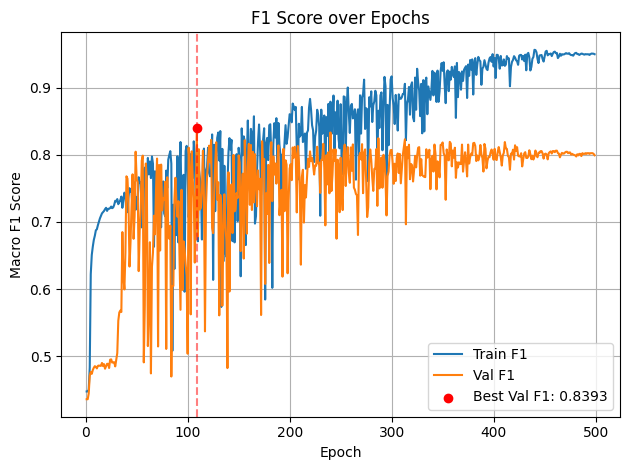

In [14]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.arange(1, len(losses_tr) + 1)

plt.plot(epochs, train_f1s, label="Train F1")
plt.plot(epochs, val_f1s, label="Val F1")
best_epoch = np.argmax(val_f1s) + 1
best_f1 = val_f1s[best_epoch - 1]
plt.scatter(best_epoch, best_f1, color="red", 
            label=f"Best Val F1: {best_f1:.4f}", zorder=5)
plt.axvline(best_epoch, color="red", linestyle="--", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Macro F1 Score")
plt.title("F1 Score over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("GIN_f1_plot.png")
plt.show()

### Load Test Dataset and Preprocess

In [15]:
clips_te = pd.read_parquet("test/segments.parquet")

dataset_te = EEGDataset(
    clips_te,  # Your test clips variable
    signals_root= "test",  # Update this path if your test signals are stored elsewhere
    signal_transform=chosen_transform,  # You can change or remove the signal_transform as needed
    prefetch=True,  # Set to False if prefetching causes memory issues on your compute environment
    return_id=True,  # Return the id of each sample instead of the label
)

dataset_te_ccor, idx = ccor_edge_attr(dataset_te, False) 
loader_test = DataLoader(dataset_te_ccor, batch_size=2**8, shuffle=False)

We had issues with reading the data ids, so we needed to modify it to match the submission format

In [16]:
def format_idx_entry(entry: str) -> str:
    parts = entry.split('___')    
    prefix, s_seg, t_seg, seq_seg = parts[0], parts[1], parts[2], parts[3]
    
    prefix_clean = prefix.replace('_', '')
    s_clean      = s_seg.replace('_', '')
    t_clean      = t_seg.replace('_', '')
    seq_clean      = seq_seg.replace('_', '')
    
    return f"{prefix_clean}_{s_clean}_{t_clean}_{seq_clean}"

def format_idx_list(idx_list: list[str]) -> list[str]:
    return [format_idx_entry(e) for e in idx_list]

### Load the Best Model Saved

In [17]:
model_loaded = GIN_with_edge(input_dim=input_dim, hidden_dim=64, dropout=0.2).to(device)

state_dict = torch.load(save_filename+".pt", map_location=device)
model_loaded.load_state_dict(state_dict)

model_loaded.to(device)

GIN_with_edge(
  (conv1): GINEConv(nn=Sequential(
    (0): Linear(in_features=74, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  ))
  (conv2): GINEConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  ))
  (lin1): Linear(in_features=192, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=1, bias=True)
)

### Predict Labels of Test Dataset

In [18]:
model_loaded.eval()
all_predictions = []
all_ids = []

with torch.no_grad():
    for batch in loader_test:

        logits = model_loaded(batch.x.to(device), batch.edge_index.to(device), batch.edge_attr.to(device), batch.batch.to(device))
        idx = batch.idx

        predictions = (torch.sigmoid(logits) > 0.5).int().cpu().numpy()

        all_predictions.extend(predictions.flatten().tolist())
        formatted = format_idx_list(idx)
        all_ids.extend(list(formatted))

submission_df = pd.DataFrame({"id": all_ids, "label": all_predictions})
submission_df.to_csv(save_filename+".csv", index=False)
print("Kaggle submission file generated: submission.csv")

Kaggle submission file generated: submission.csv
